In [6]:
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm

import folium
from folium import plugins
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString, box
import networkx as nx
import gurobipy as gb

## Load data

In [7]:
segments = pd.read_csv("segments.csv")
stops = pd.read_csv("stops.csv")

segments[["route_id", "start_stop_id", "end_stop_id"]] = segments[
    ["route_id", "start_stop_id", "end_stop_id"]
].astype(str)


def get_segment_stops(segment_df, route_id, direction_id=0):
    segment_distance = segment_df.query(
        "route_id == @route_id & direction_id == @direction_id"
    )

    stops_in_route = stops[
        stops["stop_id"].isin(
            list(
                set(
                    segment_distance[["start_stop_id", "end_stop_id"]].values.reshape(
                        -1
                    )
                )
            )
        )
    ]

    return segment_distance, stops_in_route

In [8]:
### Get stops on route
routes = ["24", "51", "67", "18", "33", "45", "80"]
route_details = {}

for r in routes:
    detail = get_segment_stops(segments, r, 0)

    route_details[r] = {}
    route_details[r]["segment"] = detail[0]
    route_details[r]["stops"] = detail[1]

stops_df = pd.concat([v["stops"] for k, v in route_details.items()]).drop_duplicates()

print(f"Number of total stops in routes: {len(stops_df)}")

stops_df["geometry"] = stops_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

stops_df_gpd = gpd.GeoDataFrame(stops_df, geometry="geometry").drop(
    columns=["location_type", "parent_station", "wheelchair_boarding"]
)

stops_df_gpd.head()

Number of total stops in routes: 326


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
1769,51241,51241,Station Villa-Maria,45.479704,-73.619643,https://www.stm.info/fr/recherche#stq=51241,POINT (-73.61964 45.47970)
1806,51281,51281,Décarie / Duquette,45.478389,-73.618050,https://www.stm.info/fr/recherche#stq=51281,POINT (-73.61805 45.47839)
1848,51326,51326,Décarie / Notre-Dame-de-Grâce,45.477244,-73.615513,https://www.stm.info/fr/recherche#stq=51326,POINT (-73.61551 45.47724)
1891,51372,51372,Décarie / Côte-Saint-Antoine,45.476312,-73.613443,https://www.stm.info/fr/recherche#stq=51372,POINT (-73.61344 45.47631)
1976,51462,51462,Décarie / Sherbrooke,45.474535,-73.609490,https://www.stm.info/fr/recherche#stq=51462,POINT (-73.60949 45.47454)


### Take a random sample of stops

In [9]:
random_stops_df_gpd = stops_df_gpd.sample(frac=0.1, random_state=2)
random_stops_df_gpd.head()

# Add a depot stop to the dataframe
depot = pd.DataFrame(
    {
        "stop_id": ["0"],
        "stop_name": ["Depot"],
        "stop_lat": [45.5048542],
        "stop_lon": [-73.5691235],
        "stop_code": 0.0,
    }
)

depot["geometry"] = Point((float(depot.stop_lon), float(depot.stop_lat)))

random_stops_df_gpd = pd.concat([depot, random_stops_df_gpd]).reset_index(drop=True)

print(f"Number of stops in sample: {len(random_stops_df_gpd)}")

random_stops_df_gpd

Number of stops in sample: 34


,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
0,0,Depot,45.504854,-73.569124,0.0,POINT (-73.5691235 45.5048542),NaN
1,51880,du Parc / du Mont-Royal,45.516693,-73.588818,51880.0,POINT (-73.588818 45.516693),https://www.stm.info/fr/recherche#stq=51880
2,51671,du Parc / Fairmount,45.520366,-73.597286,51671.0,POINT (-73.597286 45.520366),https://www.stm.info/fr/recherche#stq=51671
3,52009,Sherbrooke / Chomedey,45.492614,-73.585807,52009.0,POINT (-73.585807 45.492614),https://www.stm.info/fr/recherche#stq=52009
4,51285,du Parc / No 6659,45.528206,-73.615501,51285.0,POINT (-73.615501 45.528206),https://www.stm.info/fr/recherche#stq=51285
5,53825,Saint-Michel / William-Tremblay,45.547751,-73.561700,53825.0,POINT (-73.5617 45.547751),https://www.stm.info/fr/recherche#stq=53825
6,61839,Haig / Hochelaga,45.582393,-73.530154,61839.0,POINT (-73.530154 45.582393),https://www.stm.info/fr/recherche#stq=61839
7,62057,Papineau / Jacques-Casault,45.555471,-73.623566,62057.0,POINT (-73.623566 45.555471),https://www.stm.info/fr/recherche#stq=62057
8,51086,Queen-Mary / Lemieux,45.486787,-73.626289,51086.0,POINT (-73.626289 45.486787),https://www.stm.info/fr/recherche#stq=51086
9,51551,Beaubien / Saint-Hubert,45.535993,-73.603111,51551.0,POINT (-73.603111 45.535993),https://www.stm.info/fr/recherche#stq=51551


## Calculate distance matrix

In [10]:
# G = ox.graph_from_place("Montreal, Canada", network_type="drive")
# G = ox.load_graphml("montreal_drive.graphml")

In [11]:
print(f"Number of stops: {len(random_stops_df_gpd)}")
distance_matrix = pd.read_json("distance_matrix.json")

distance_matrix.columns = distance_matrix.columns.astype(str)
distance_matrix.index = distance_matrix.index.astype(str)

Number of stops: 34


In [12]:
# Run if stops change

# print(f"Number of stops: {len(random_stops_df_gpd)}")

# distance_matrix = np.zeros((len(random_stops_df_gpd), len(random_stops_df_gpd)))
# for i, stop1 in enumerate(random_stops_df_gpd.itertuples()):
#     print(f"Calculating distance for stop {i}")
#     for j in range(i + 1, len(random_stops_df_gpd)):
#         stop2 = random_stops_df_gpd.iloc[j]

#         origin = ox.nearest_nodes(G, stop1.stop_lon, stop1.stop_lat)
#         destination = ox.nearest_nodes(G, stop2.stop_lon, stop2.stop_lat)

#         try:
#             distance = nx.shortest_path_length(G, origin, destination, weight="length")
#         except nx.NetworkXNoPath:
#             distance = np.Inf

#         distance_matrix[i, j] = distance
#         distance_matrix[j, i] = distance

#     print("-" * 100)

# distance_matrix = pd.DataFrame(
#     distance_matrix / 1000,
#     columns=random_stops_df_gpd.stop_id,
#     index=random_stops_df_gpd.stop_id,
# )

# distance_matrix.to_json("distance_matrix.json")

## Find disaster nodes

In [60]:
disaster_area = box(minx=-73.5703, miny=45.5668, maxx=-73.53963, maxy=45.60587)

random_stops_df_gpd = gpd.GeoDataFrame(random_stops_df_gpd, geometry="geometry")

stops_in_disaster_area = random_stops_df_gpd[
    random_stops_df_gpd.within(disaster_area)
]

stops_in_disaster_area

,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
14,54511,des Roseraies / Louis-H.-La Fontaine,45.596796,-73.549701,54511.0,POINT (-73.54970 45.59680),https://www.stm.info/fr/recherche#stq=54511
30,52748,Langelier / Beaubien,45.588475,-73.560248,52748.0,POINT (-73.56025 45.58848),https://www.stm.info/fr/recherche#stq=52748
33,52657,Langelier / Michel-Bouvier,45.589271,-73.562881,52657.0,POINT (-73.56288 45.58927),https://www.stm.info/fr/recherche#stq=52657


## View stops in sample

In [61]:
stops_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(stops_map)

for stop in random_stops_df_gpd.itertuples():
    folium.CircleMarker(
        location=[stop.stop_lat, stop.stop_lon],
        radius=5,
        color="skyblue",
        fill=True,
        fill_opacity=1,
        fill_color="skyblue",
        tooltip=f"{stop.stop_name} ({stop.stop_id})",
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(stops_map)

folium.plugins.Fullscreen(position="topright").add_to(stops_map)
folium.plugins.MousePosition(position="topright").add_to(stops_map)

stops_map

## Capacity vehicle routing problem

### Parameters

In [9]:
rng = np.random.default_rng(2)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

demand = {stop: rng.integers(10, 30) for stop in stops}
demand[stops[0]] = 0

num_buses = 10
BUS_CAPACITY = 100

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 556
Total capacity: 1000


### Model

In [16]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 30

# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in stops for j in stops for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops) == gb.quicksum(x[i, j, k] for j in stops)
        for i in stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[stops[0], j, k] for j in stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(demand[j] * x[i, j, k] for j in stops[1:] for i in stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= demand[i] for i in stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 5
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 30


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17237 rows, 9030 columns and 67928 nonzeros
Model fingerprint: 0x607381bc
Variable types: 0 continuous, 9030 integer (9000 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 13808 rows and 5341 columns
Presolve time: 0.09s
Presolved: 3429 rows, 3689 columns, 23590 nonzeros
Variable types: 0 continuous, 3689 integer (3660 binary)

Root relaxation: objective 4.164521e+01, 343 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   41.64521    0   58          -   41.

In [17]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x for i in stops for j in stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

Objective value: 119.15 km


,bus,distance
0,0,16.096117
1,1,15.275332
2,2,37.329649
3,3,25.140495
4,4,8.483708
5,9,16.829528


### Optimal solution routes

In [13]:
# Bus path
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in stops:
        for j in stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to df with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)

bus_path_df["demand"] = bus_path_df["end_stop"].map(demand)

bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

print(f"Number of buses used: {bus_path_df.bus.nunique()}")

bus_path_df

Number of buses used: 6


,start_stop,end_stop,distance,bus,step,stop_id,stop_name,geometry,demand,step_demand
0,0,53825,5.284871,0,0,53825,Saint-Michel / William-Tremblay,POINT (-73.56170 45.54775),26,26
1,53825,52239,1.214329,0,1,52239,Saint-Michel / Dandurand,POINT (-73.57609 45.55195),18,44
2,52239,60634,1.541966,0,2,60634,Beaubien / 20e Avenue,POINT (-73.58096 45.56102),24,68
3,60634,51983,0.624541,0,3,51983,Beaubien / 13e Avenue,POINT (-73.58513 45.55626),21,89
4,51983,0,7.430410,0,4,0,Depot,POINT (-73.56912 45.50485),0,89
5,0,51695,6.188007,1,0,51695,Beaubien / Chabot,POINT (-73.59558 45.54418),22,22
6,51695,51629,0.477603,1,1,51629,Beaubien / De Lanaudière,POINT (-73.59895 45.54056),27,49
7,51629,51551,0.605158,1,2,51551,Beaubien / Saint-Hubert,POINT (-73.60311 45.53599),16,65
8,51551,51093,2.414556,1,3,51093,Station Parc (Hutchison / Ogilvy),POINT (-73.62426 45.53017),16,81
9,51093,51285,0.798491,1,4,51285,du Parc / No 6659,POINT (-73.61550 45.52821),18,99


In [14]:
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Route 1: 0 -> 53825 -> 52239 -> 60634 -> 51983 -> 0
Route 2: 0 -> 51695 -> 51629 -> 51551 -> 51093 -> 51285 -> 0
Route 3: 0 -> 62057 -> 54395 -> 55046 -> 55294 -> 55218 -> 0
Route 4: 0 -> 52720 -> 51943 -> 52657 -> 52748 -> 54511 -> 0
Route 5: 0 -> 56196 -> 56205 -> 51671 -> 51712 -> 51880 -> 0
Route 10: 0 -> 52009 -> 51167 -> 51146 -> 51086 -> 51372 -> 0


Bus 1:


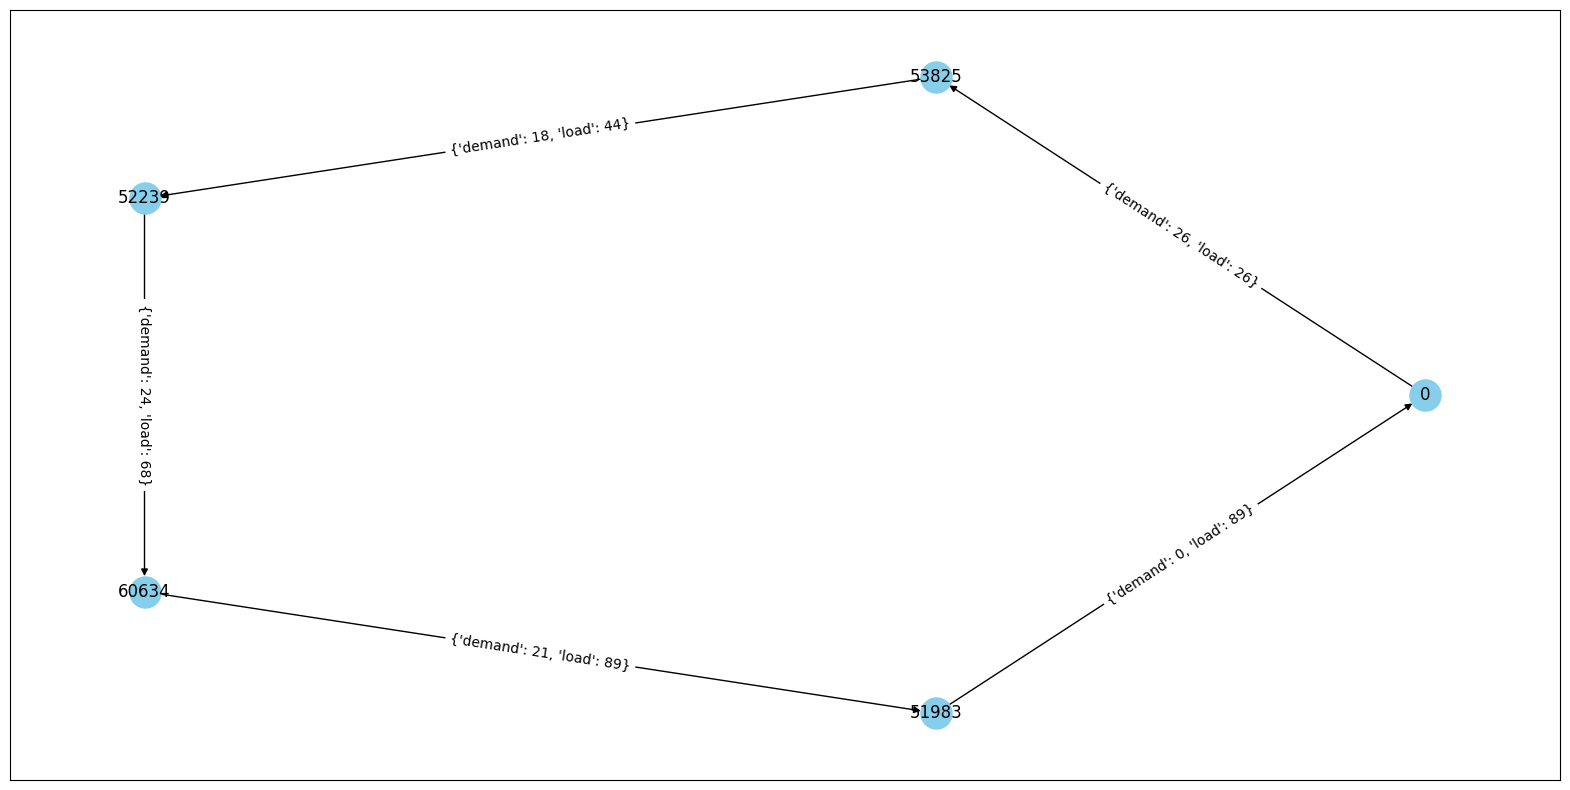



Bus 2:


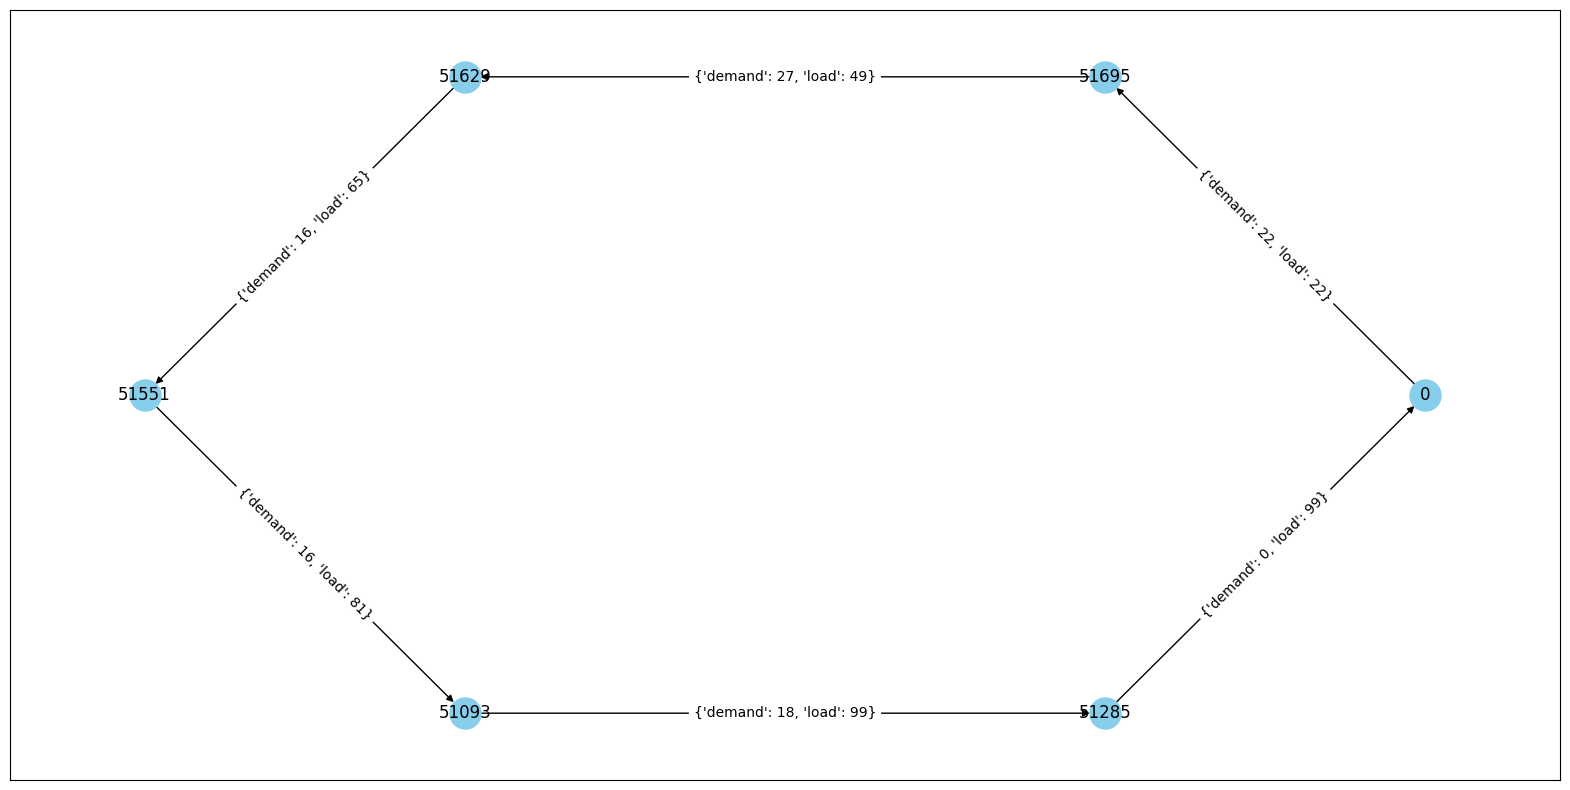



Bus 3:


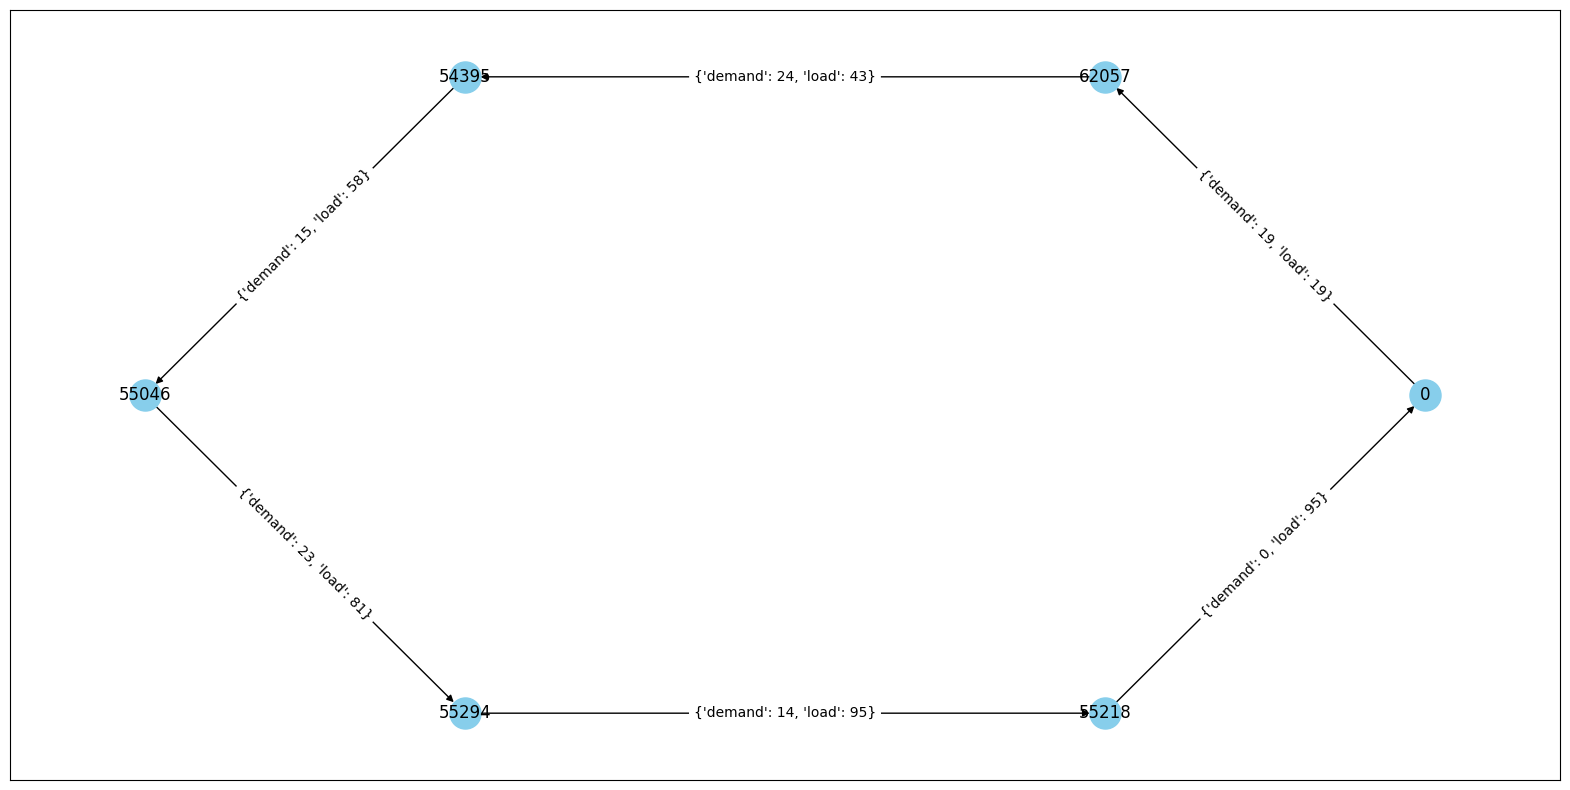



Bus 4:


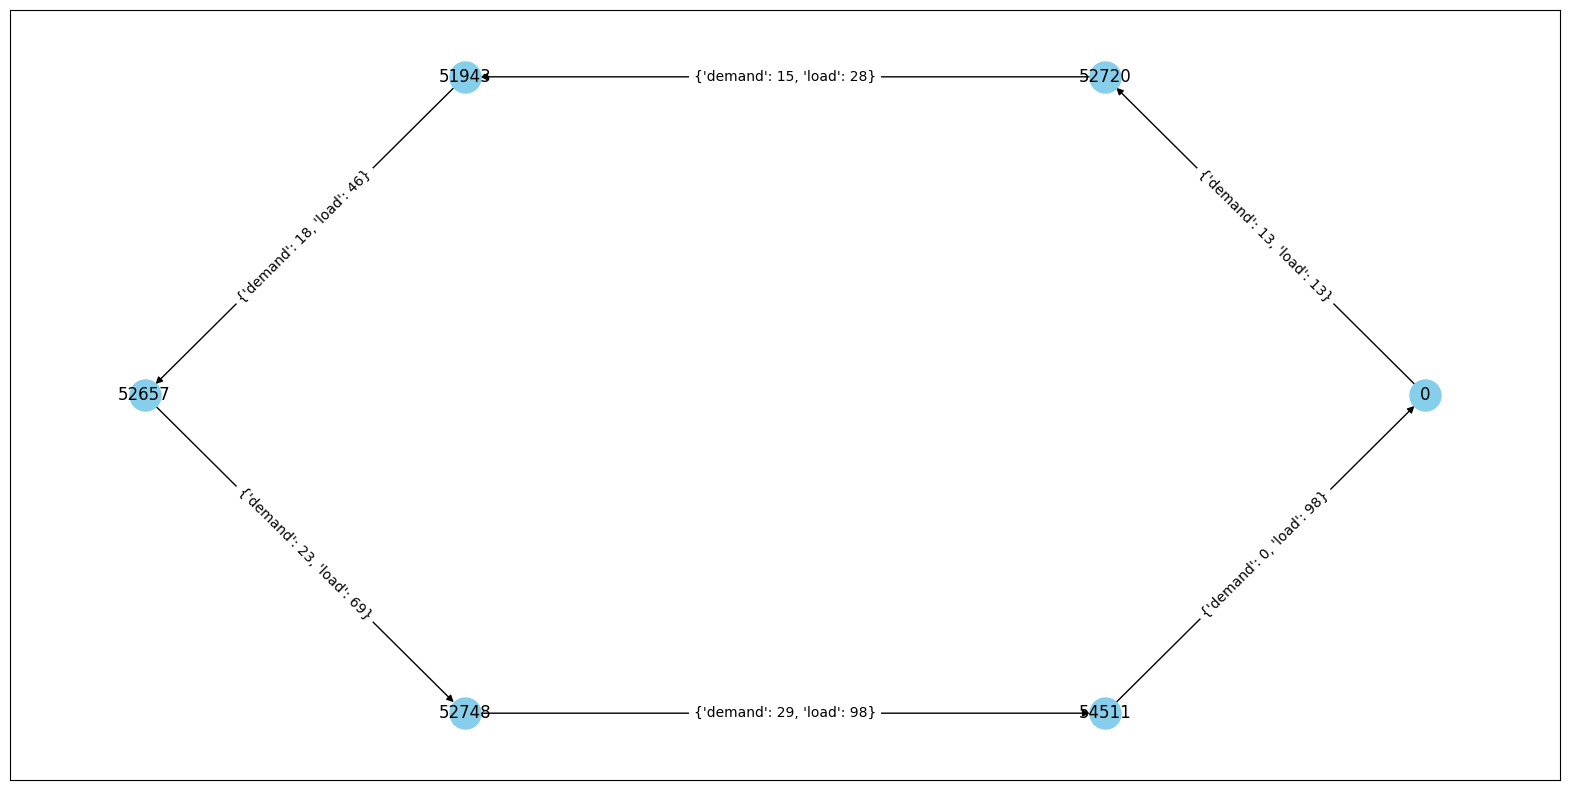



Bus 5:


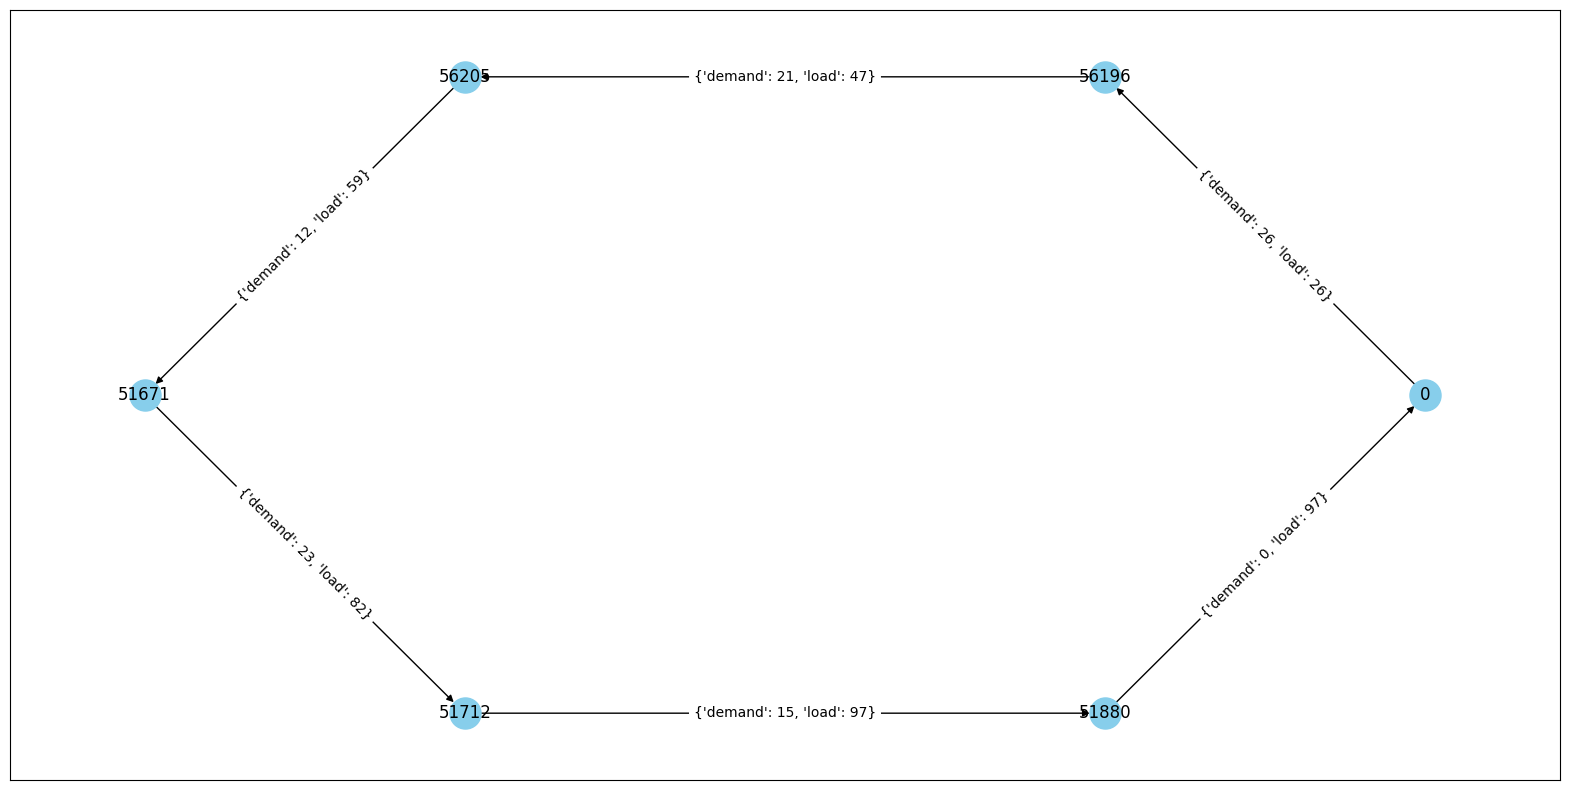



Bus 10:


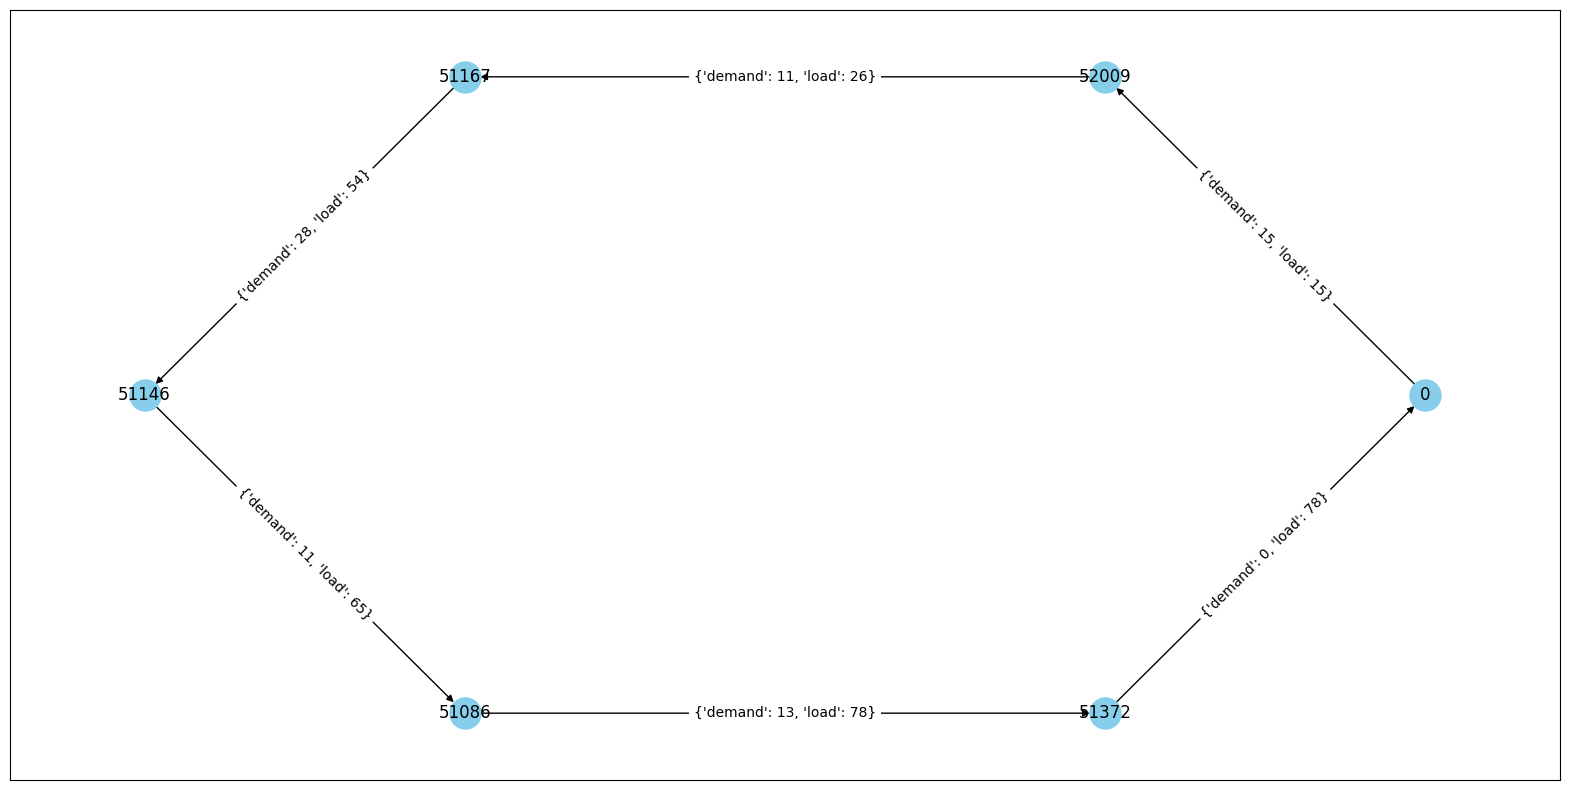

In [15]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [16]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

routes_gdf

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.56170 45.5...",89
1,1,"LINESTRING (-73.56912 45.50485, -73.59558 45.5...",99
2,2,"LINESTRING (-73.56912 45.50485, -73.62357 45.5...",95
3,3,"LINESTRING (-73.56912 45.50485, -73.56303 45.5...",98
4,4,"LINESTRING (-73.56912 45.50485, -73.61093 45.5...",97
5,9,"LINESTRING (-73.56912 45.50485, -73.58581 45.4...",78


### Map the routes

In [17]:
colormap = cm.get_cmap("tab10")

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(name=f"Route {route.Index + 1}")

    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=mcolors.rgb2hex(colormap.colors[route.Index]),
        weight=3,
        opacity=0.8,
        tooltip=f"Route {route.Index + 1}",
        popup=f"""
        <div>
            <h5>Route {route.Index + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map

## Split delivery vehicle routing problem

### Parameters

In [62]:
rng = np.random.default_rng(3)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

distance_matrix_model = distance_matrix_model.loc[stops, stops]

demand = {stop: rng.integers(1, 100) for stop in stops}
demand[stops[0]] = 0

num_buses = 20
BUS_CAPACITY = 75

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 1296
Total capacity: 1500


In [63]:
def split_demand(node_demand):
    S = 100
    fraction = [2 ** (i - 1) for i in range(1, S + 1)]
    demands = [round(node_demand * f / sum(fraction), 0) for f in fraction]

    demands = list(filter(lambda x: x > 0, demands))

    if sum(demands) < node_demand:
        demands[-1] += node_demand - sum(demands)

    if demands[-1] >= BUS_CAPACITY:
        new_demand = split_demand(demands[-1])
        demands.pop()
        demands.extend(new_demand)

    return demands


def split_demand_node(demand, node):
    node_demand = demand[node]
    demands = split_demand(node_demand)

    return {f"{node}_{i}": d for i, d in enumerate(demands)}


nodes_exceeding_demand = {}
new_demand = demand.copy()
for k, v in demand.items():
    if v > BUS_CAPACITY:
        new_nodes = split_demand_node(demand, k)

        new_demand.pop(k)
        new_demand.update(new_nodes)

        nodes_exceeding_demand[k] = new_nodes

print(f"New nodes added for: {nodes_exceeding_demand.keys()}")

for node in nodes_exceeding_demand:
    for i in range(1, len([k for k in new_demand.keys() if node in k])):
        distance_matrix_model[f"{node}_{i}"] = distance_matrix_model[node]
        distance_matrix_model.loc[f"{node}_{i}"] = distance_matrix_model.loc[node]
        distance_matrix_model.loc[f"{node}_{i}", node] = 0
    distance_matrix_model.drop(columns=[node], index=[node], inplace=True)


distance_matrix_model

New nodes added for: dict_keys(['53825', '61839', '53478'])


,0,51880,51671,52009,51285,62057,51086,51551,51695,56196,...,61839_3,61839_4,61839_5,61839_6,53478_1,53478_2,53478_3,53478_4,53478_5,53478_6
0,0.000000,2.215283,2.977427,2.105735,4.629537,8.603922,5.646553,5.279644,6.188007,3.925894,...,9.667088,9.667088,9.667088,9.667088,10.446752,10.446752,10.446752,10.446752,10.446752,10.446752
51880,2.215283,0.000000,0.762144,3.594016,2.414254,6.589459,5.276945,3.202800,4.173544,1.779053,...,9.400414,9.400414,9.400414,9.400414,11.252800,11.252800,11.252800,11.252800,11.252800,11.252800
51671,2.977427,0.762144,0.000000,4.356160,1.652110,5.903767,5.196458,2.526108,3.506030,1.580387,...,9.996724,9.996724,9.996724,9.996724,11.876905,11.876905,11.876905,11.876905,11.876905,11.876905
52009,2.105735,3.594016,4.356160,0.000000,6.009509,10.107816,4.603822,6.783538,7.691901,5.305866,...,11.170982,11.170982,11.170982,11.170982,12.358669,12.358669,12.358669,12.358669,12.358669,12.358669
51285,4.629537,2.414254,1.652110,6.009509,0.000000,4.404189,6.170816,2.032940,3.111695,2.509823,...,11.217474,11.217474,11.217474,11.217474,13.279912,13.279912,13.279912,13.279912,13.279912,13.279912
62057,8.603922,6.589459,5.903767,10.107816,4.404189,0.000000,10.200248,3.478528,2.700424,6.476064,...,9.717248,9.717248,9.717248,9.717248,11.833762,11.833762,11.833762,11.833762,11.833762,11.833762
51086,5.646553,5.276945,5.196458,4.603822,6.170816,10.200248,0.000000,7.242233,8.324994,3.970265,...,14.620374,14.620374,14.620374,14.620374,15.895893,15.895893,15.895893,15.895893,15.895893,15.895893
51551,5.279644,3.202800,2.526108,6.783538,2.032940,3.478528,7.242233,0.000000,1.082761,3.244922,...,9.359759,9.359759,9.359759,9.359759,11.436149,11.436149,11.436149,11.436149,11.436149,11.436149
51695,6.188007,4.173544,3.506030,7.691901,3.111695,2.700424,8.324994,1.082761,0.000000,4.327683,...,8.276998,8.276998,8.276998,8.276998,10.353388,10.353388,10.353388,10.353388,10.353388,10.353388
56196,3.925894,1.779053,1.580387,5.305866,2.509823,6.476064,3.970265,3.244922,4.327683,0.000000,...,11.185501,11.185501,11.185501,11.185501,13.030838,13.030838,13.030838,13.030838,13.030838,13.030838


In [64]:
new_stops = list(distance_matrix_model.columns)
num_new_stops = len(new_stops)

print(f"Total number of stops (overall): {num_stops}")
print(f"Total number of stops (including splits): {num_new_stops}")

Total number of stops (overall): 31
Total number of stops (including splits): 46


### Model

In [65]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 60 * 3

# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    new_stops,
    new_stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in new_stops for j in new_stops for k in range(num_buses)
    ),
)

u = model.addVars(
    new_stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in new_stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in new_stops
        for j in new_stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in new_stops) == gb.quicksum(x[i, j, k] for j in new_stops)
        for i in new_stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in new_stops for k in range(num_buses)) == 1
        for j in new_stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[new_stops[0], j, k] for j in new_stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(new_demand[j] * x[i, j, k] for j in new_stops[1:] for i in new_stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in new_stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= new_demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= new_demand[i] for i in new_stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in new_stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 5
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 180
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 82115 rows, 42366 columns and 324110 nonzeros
Model fingerprint: 0x36f3ed47
Variable types: 0 continuous, 42366 integer (42320 binary)
Coefficient statistics:
  Matrix range     [2e-01, 8e+01]
  Objective range  [2e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 72409 rows and 31786 columns
Presolve time: 0.47s
Presolved: 9706 rows, 10580 columns, 67580 nonzeros
Variable types: 0 continuous, 10580 integer (10540 binary)

Root relaxation: objective 1.391302e+02, 1447 iterations, 0.09 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   

In [66]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x for i in new_stops for j in new_stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

Objective value: 304.22 km


,bus,distance
0,0,7.134282
1,1,25.278090
2,2,10.547444
3,3,17.662052
4,4,5.626274
5,5,9.951426
6,6,19.334176
7,7,21.600610
8,8,34.566931
9,9,20.893504


### Optimal solution routes

In [67]:
# Bus path
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in new_stops:
        for j in new_stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to df with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df["demand"] = bus_path_df["end_stop"].map(new_demand)

bus_path_df[["start_stop", "end_stop"]] = bus_path_df[
    ["start_stop", "end_stop"]
].applymap(lambda x: x.split("_")[0])


bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)


bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

print(f"Number of buses used: {bus_path_df.bus.nunique()}")

bus_path_df

Number of buses used: 19


,start_stop,end_stop,distance,bus,step,demand,stop_id,stop_name,geometry,step_demand
0,0,56205,3.567141,0,0,73.0,56205,Côte-Sainte-Catherine / Stuart,POINT (-73.60653 45.51520),73.0
1,56205,0,3.567141,0,1,0.0,0,Depot,POINT (-73.56912 45.50485),73.0
2,0,55046,12.639045,1,0,42.0,55046,Saint-Michel / Prieur,POINT (-73.64608 45.58137),42.0
3,55046,0,12.639045,1,1,0.0,0,Depot,POINT (-73.56912 45.50485),42.0
4,0,51146,5.273722,2,0,75.0,51146,Queen-Mary / Roslyn,POINT (-73.62370 45.48968),75.0
...,...,...,...,...,...,...,...,...,...,...
59,51372,0,7.000705,18,3,0.0,0,Depot,POINT (-73.56912 45.50485),71.0
60,0,61839,9.667088,19,0,11.0,61839,Haig / Hochelaga,POINT (-73.53015 45.58239),11.0
61,61839,53478,2.073767,19,1,11.0,53478,Notre-Dame / No 7200,POINT (-73.51077 45.58234),22.0
62,53478,53242,2.811900,19,2,48.0,53242,Sherbrooke / Lepailleur,POINT (-73.53564 45.59520),70.0


In [68]:
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Route 1: 0 -> 56205 -> 0
Route 2: 0 -> 55046 -> 0
Route 3: 0 -> 51146 -> 0
Route 4: 0 -> 54395 -> 0
Route 5: 0 -> 51712 -> 0
Route 6: 0 -> 51167 -> 0
Route 7: 0 -> 61839_5 -> 61839_1 -> 61839_2 -> 61839_6 -> 61839_3 -> 0
Route 8: 0 -> 53478_3 -> 53478_1 -> 54311 -> 53478_2 -> 0
Route 9: 0 -> 55294 -> 55218 -> 0
Route 10: 0 -> 53478_6 -> 53478_5 -> 0
Route 11: 0 -> 53825_1 -> 53825_4 -> 60634 -> 0
Route 12: 0 -> 52239 -> 51983 -> 51943 -> 0
Route 13: 0 -> 51671 -> 51093 -> 51285 -> 0
Route 14: 0 -> 51880 -> 56196 -> 0
Route 16: 0 -> 53825_6 -> 53825_5 -> 53825_2 -> 53825_3 -> 0
Route 17: 0 -> 51551 -> 51695 -> 52720 -> 0
Route 18: 0 -> 51629 -> 62057 -> 0
Route 19: 0 -> 52009 -> 51086 -> 51372 -> 0
Route 20: 0 -> 61839_4 -> 53478_4 -> 53242 -> 0


Bus 1:


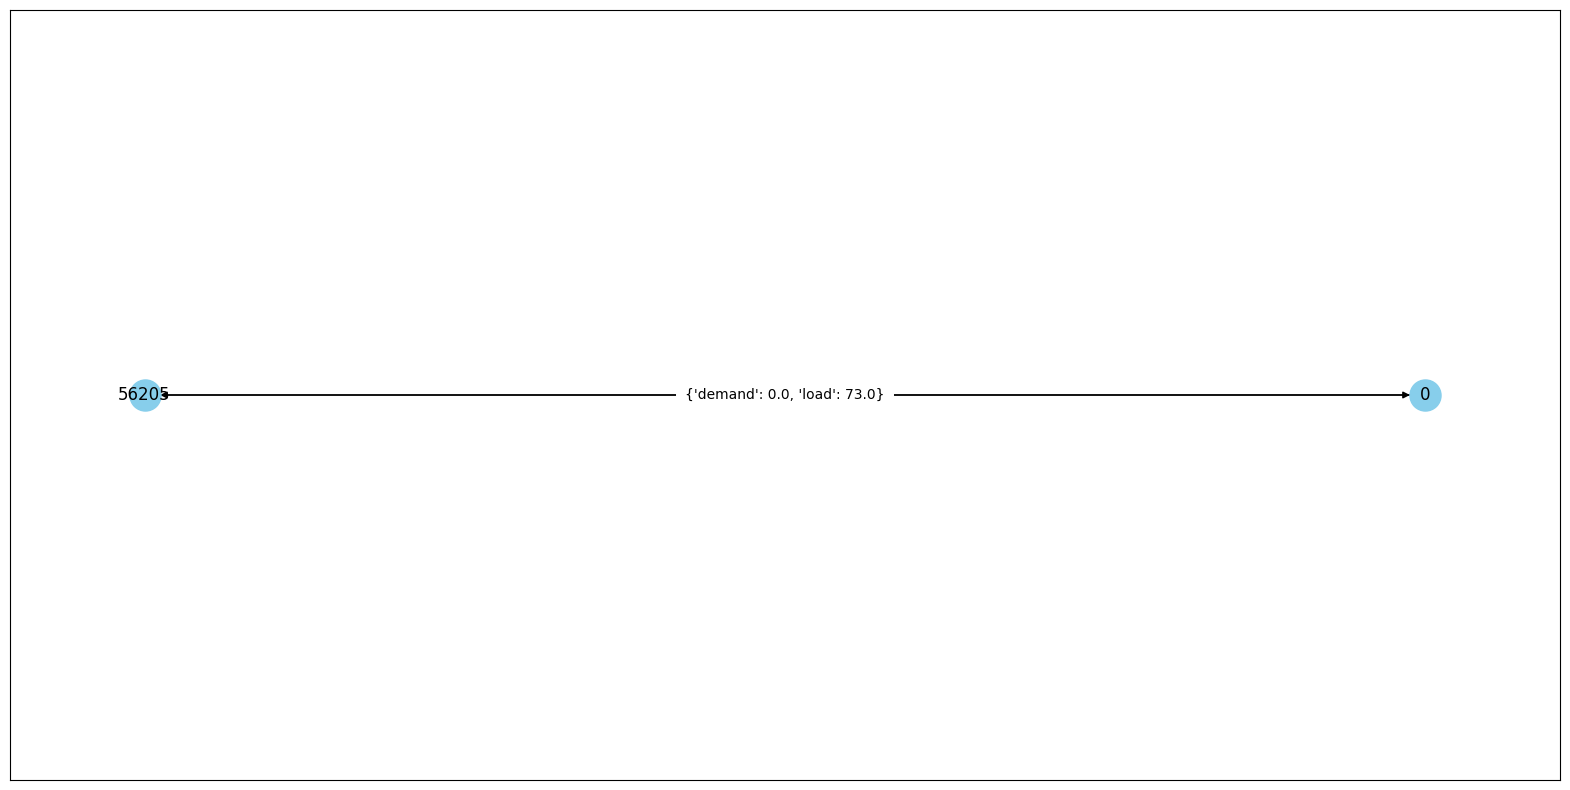



Bus 2:


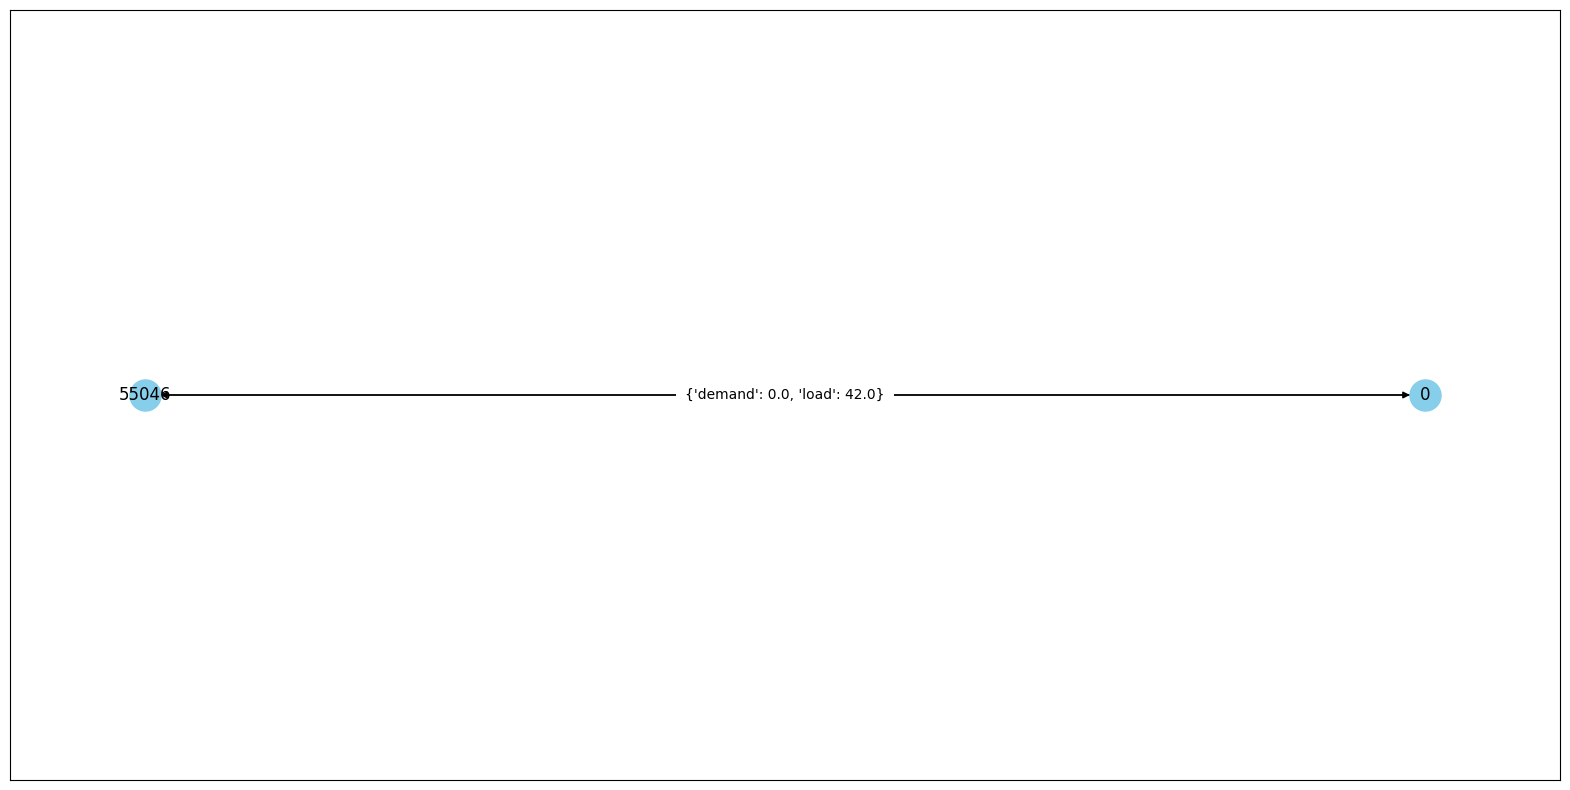



Bus 3:


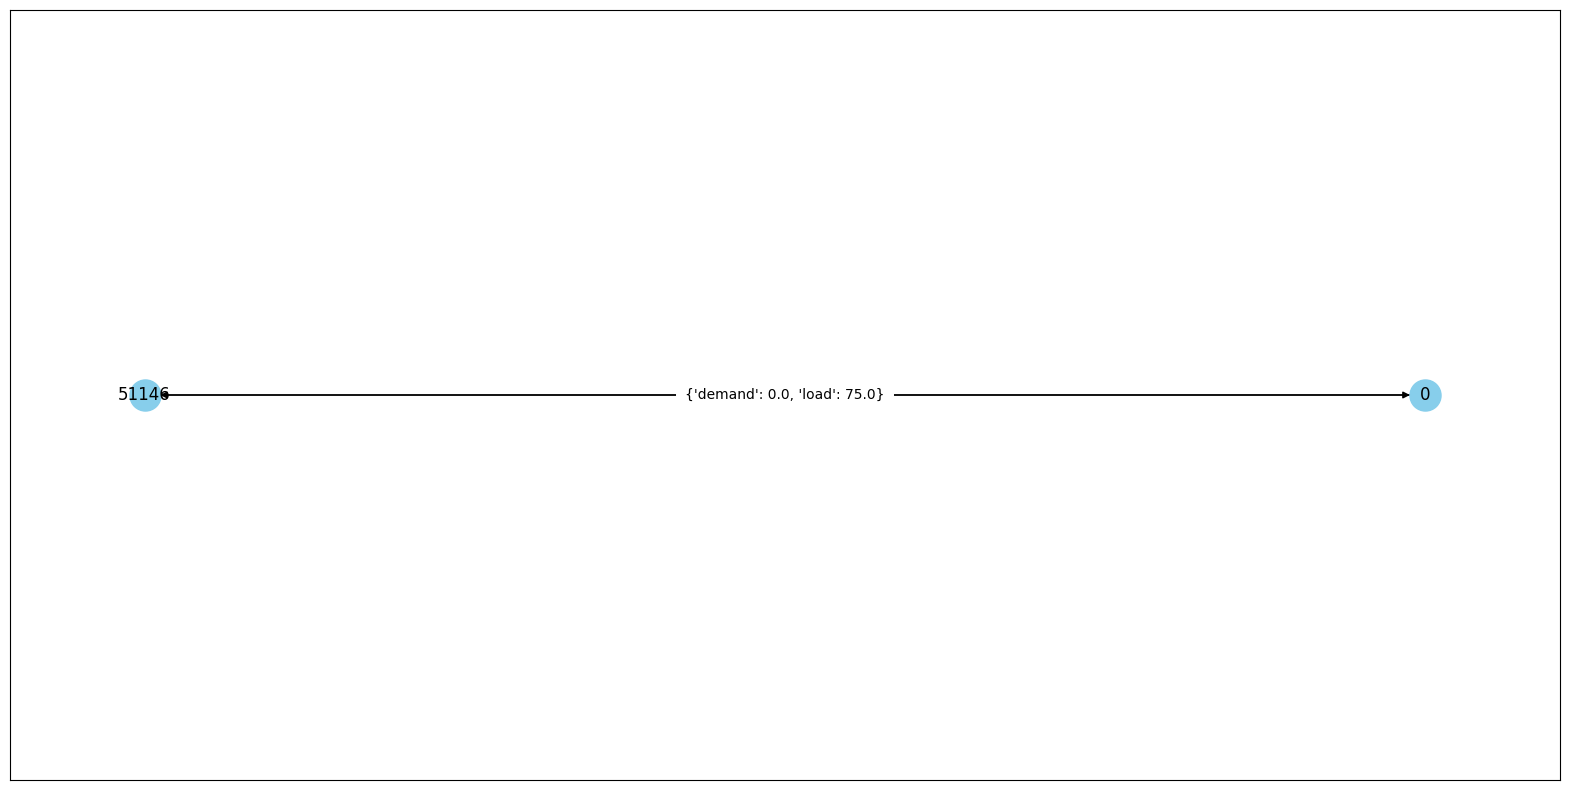



Bus 4:


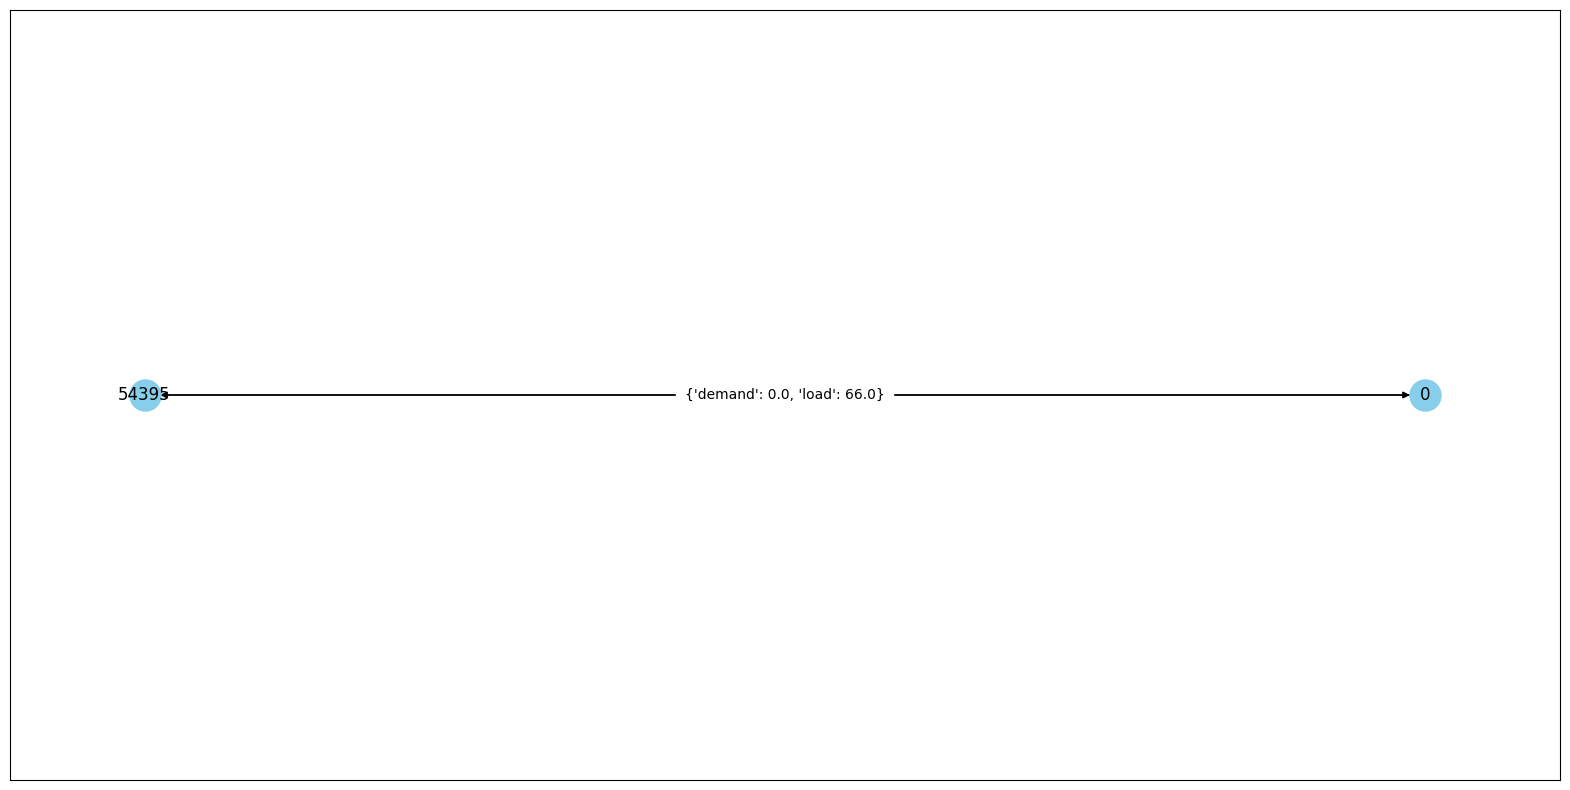



Bus 5:


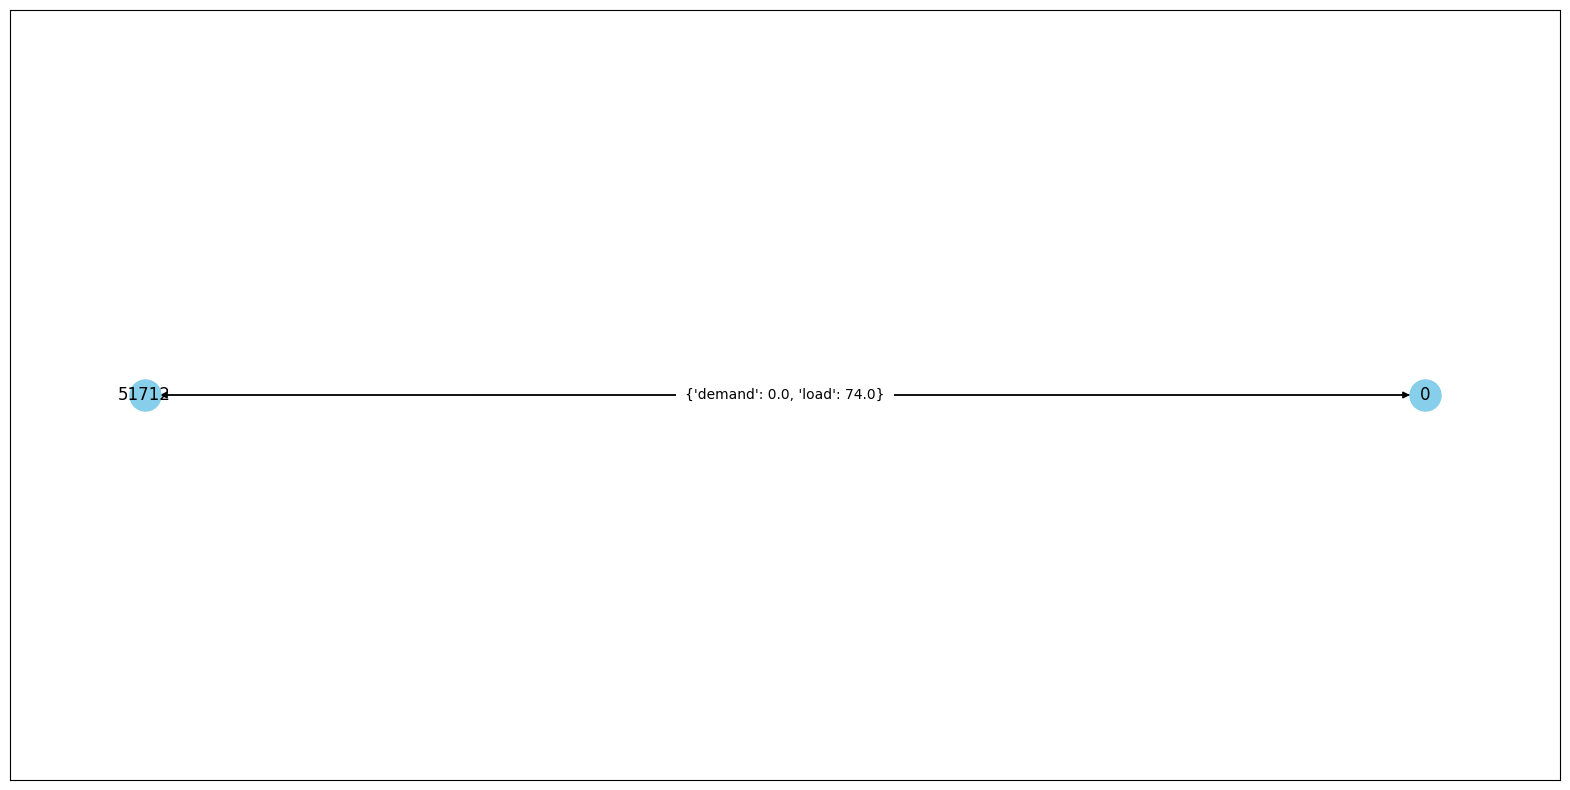



Bus 6:


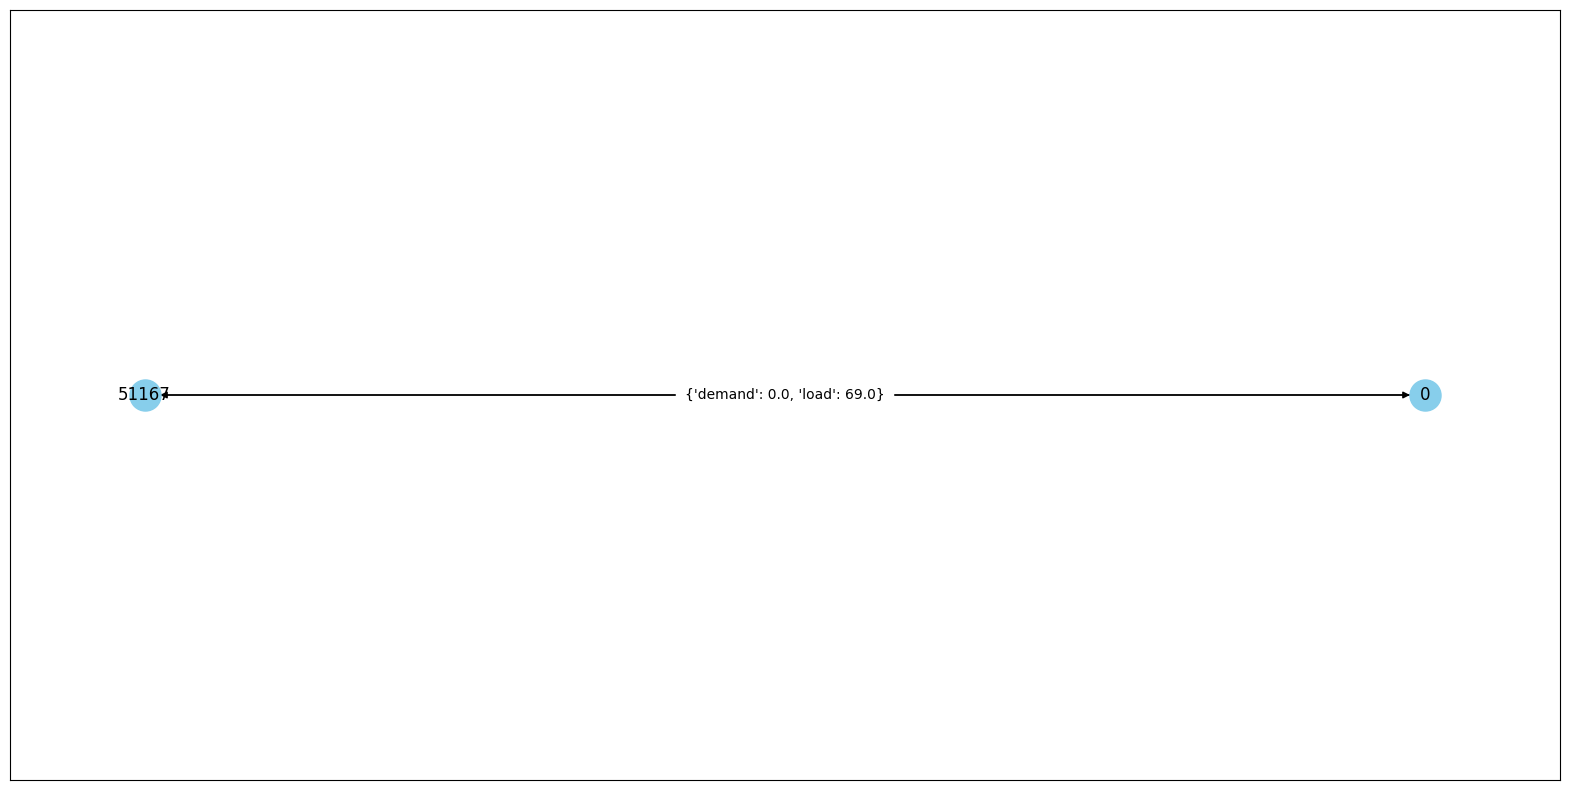



Bus 7:


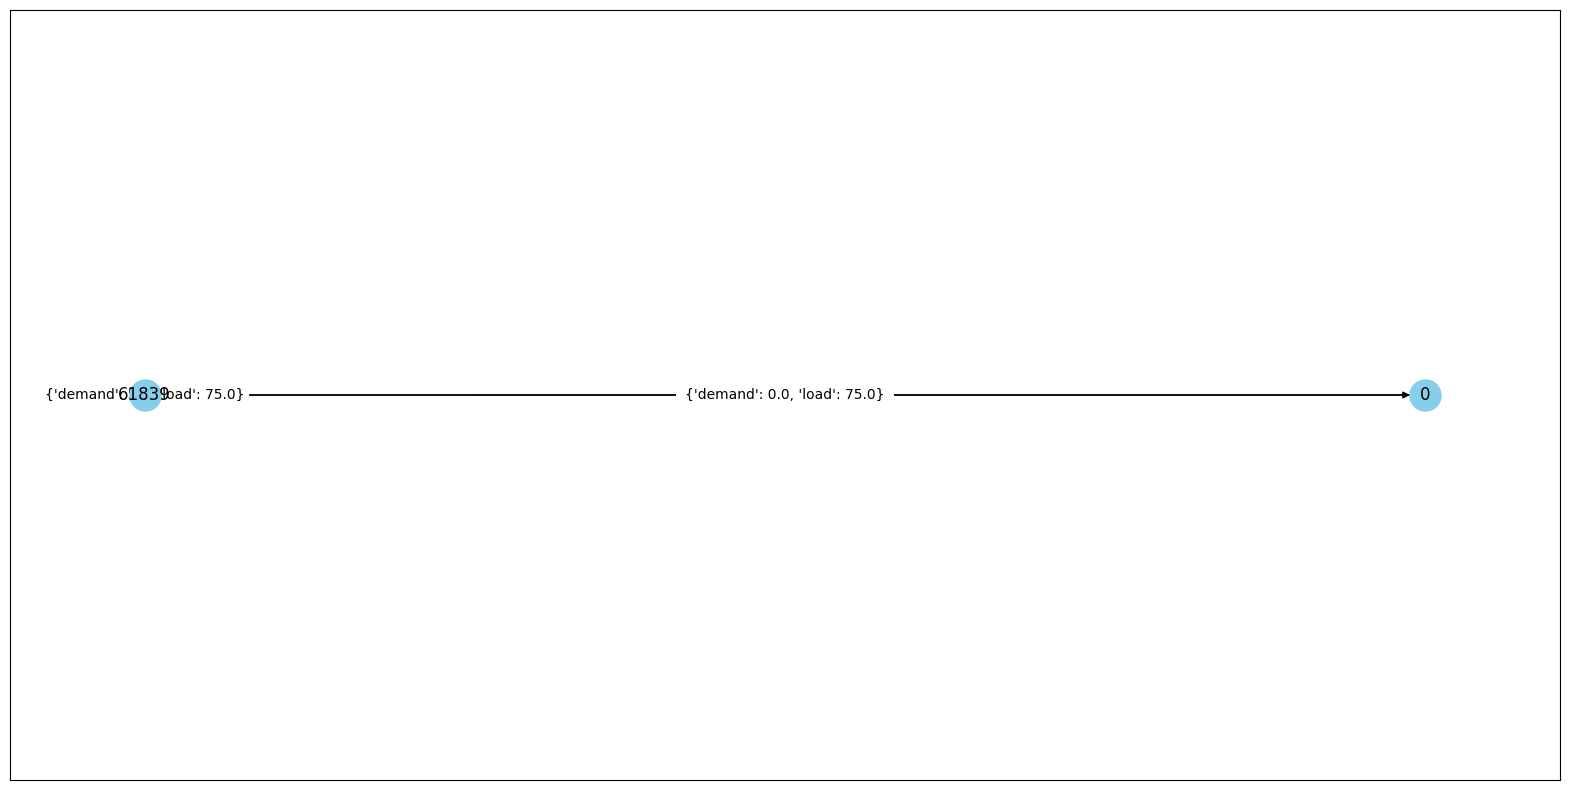



Bus 8:


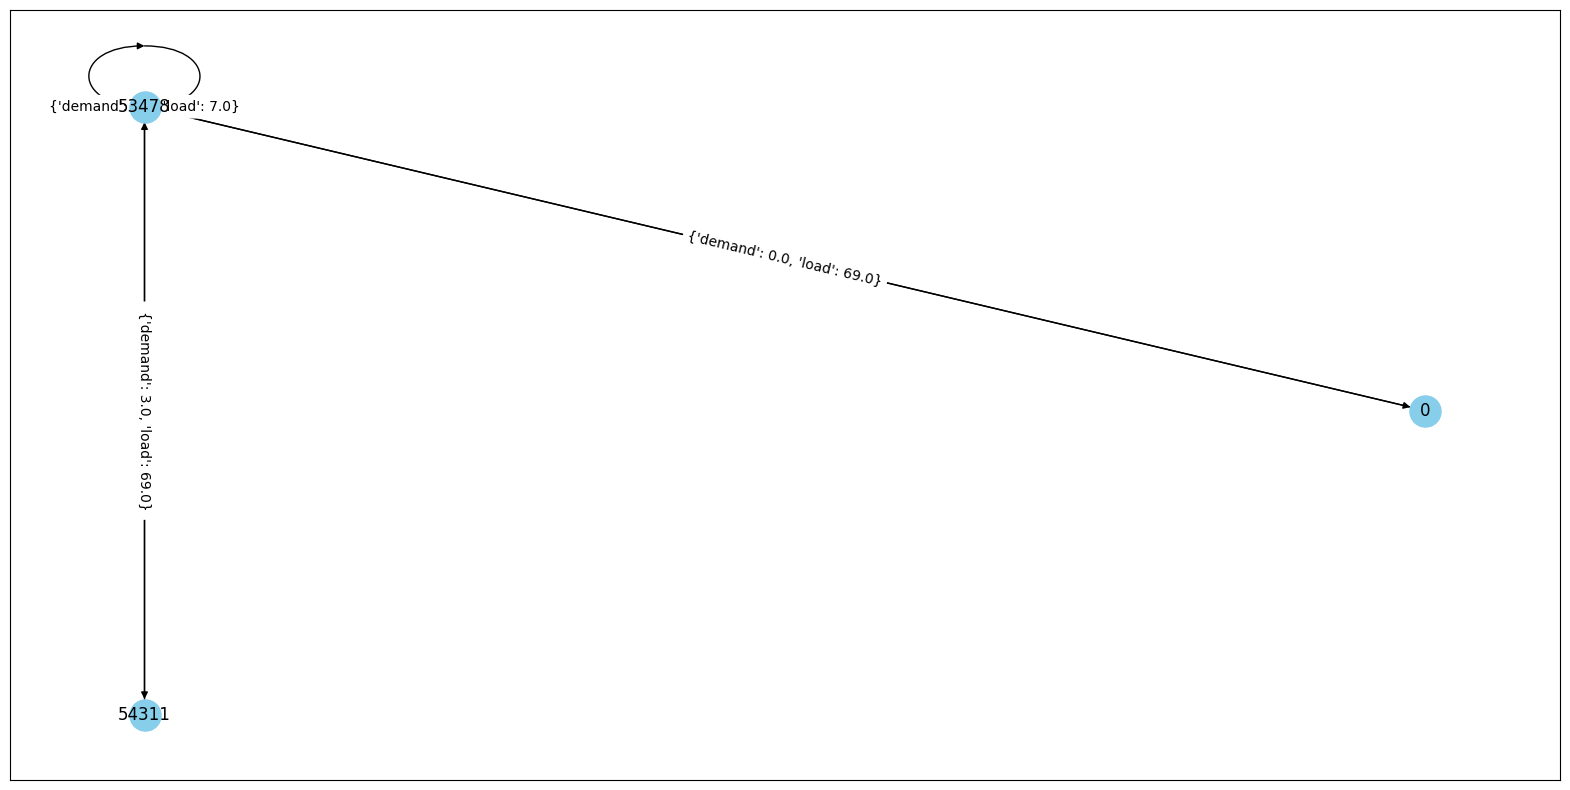



Bus 9:


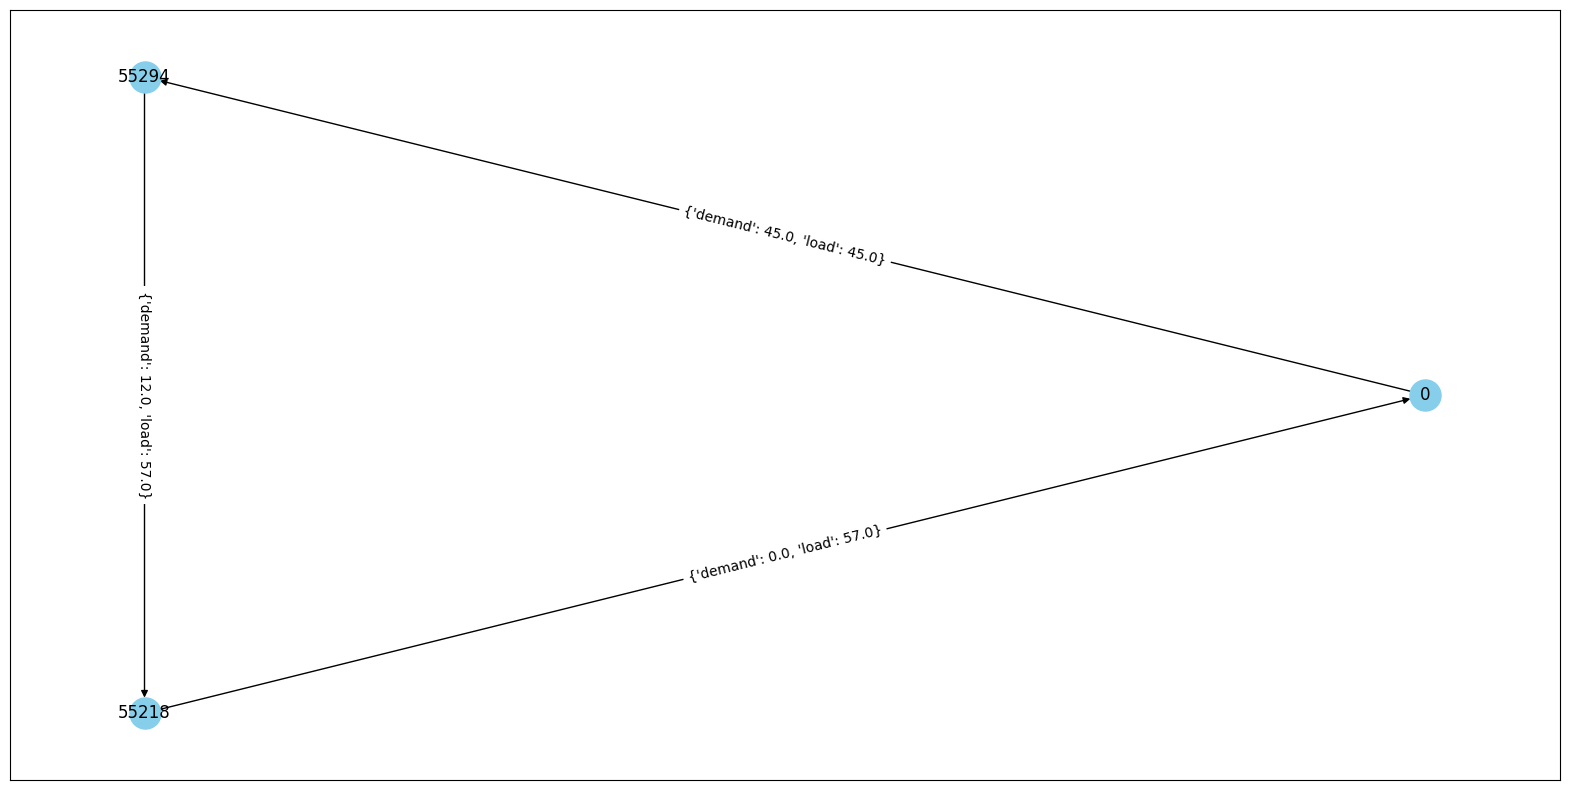



Bus 10:


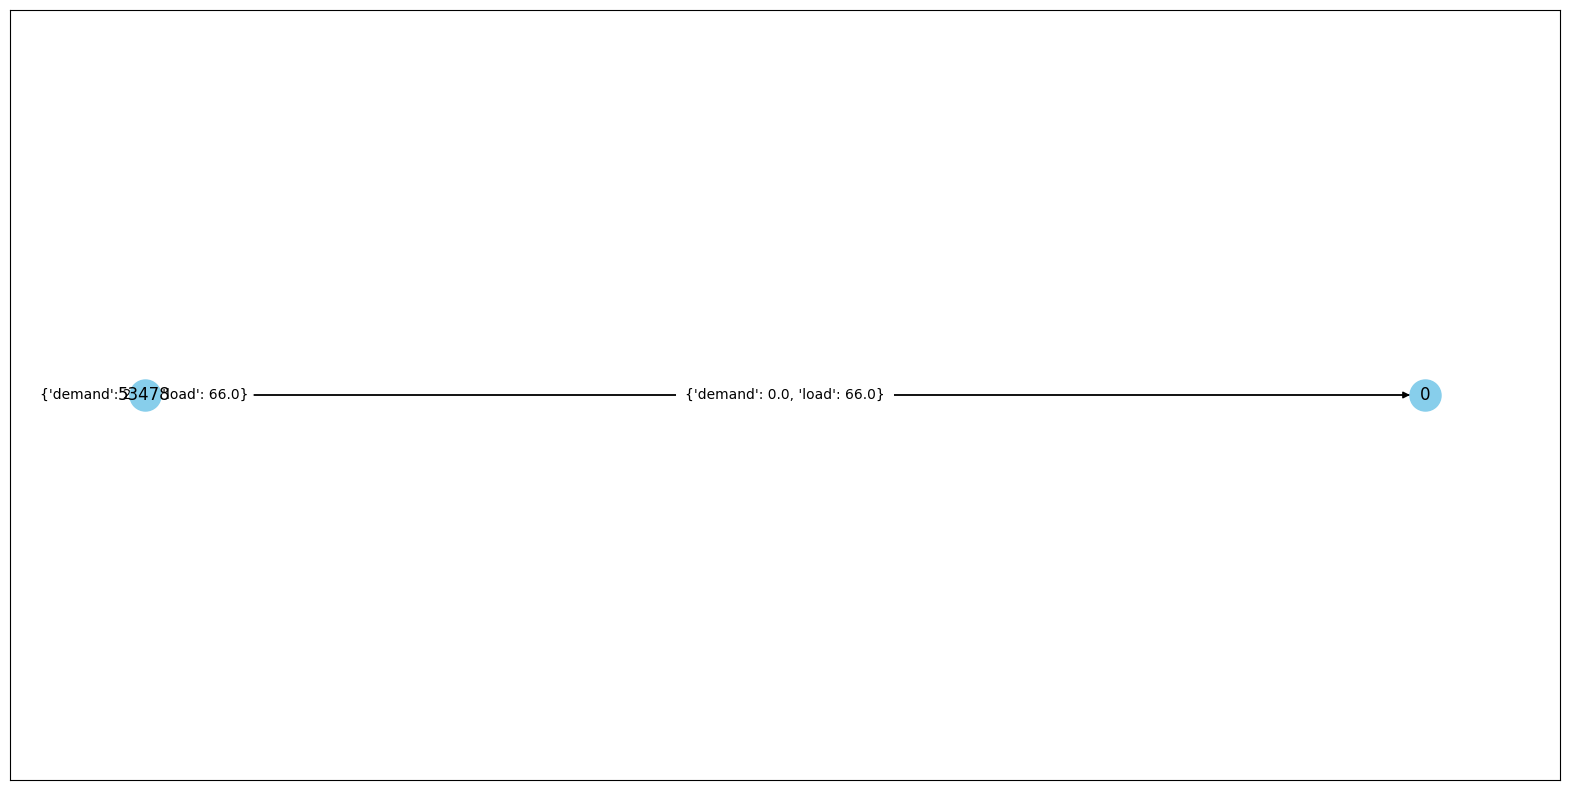



Bus 11:


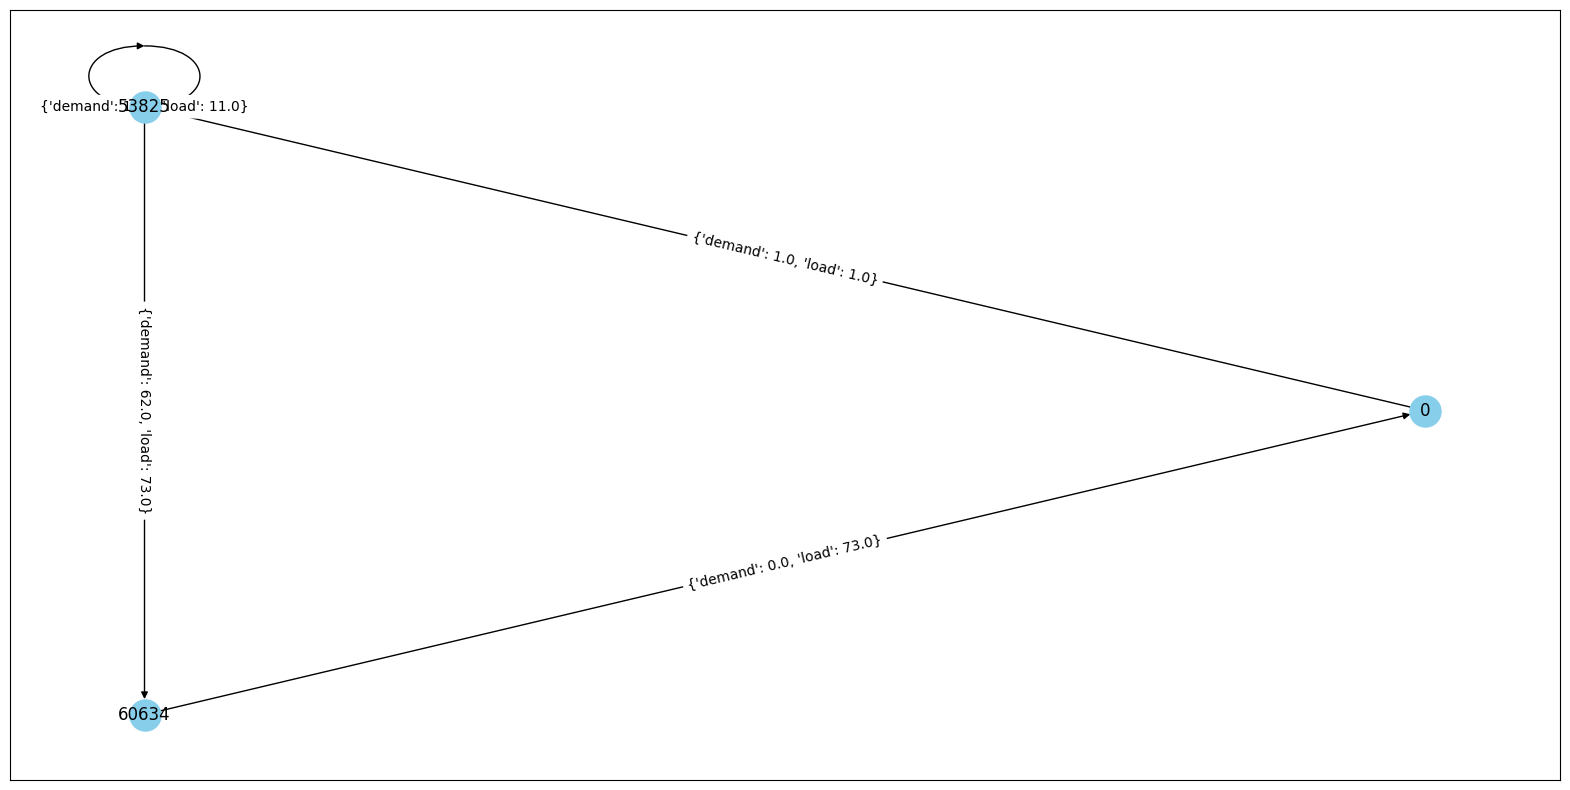



Bus 12:


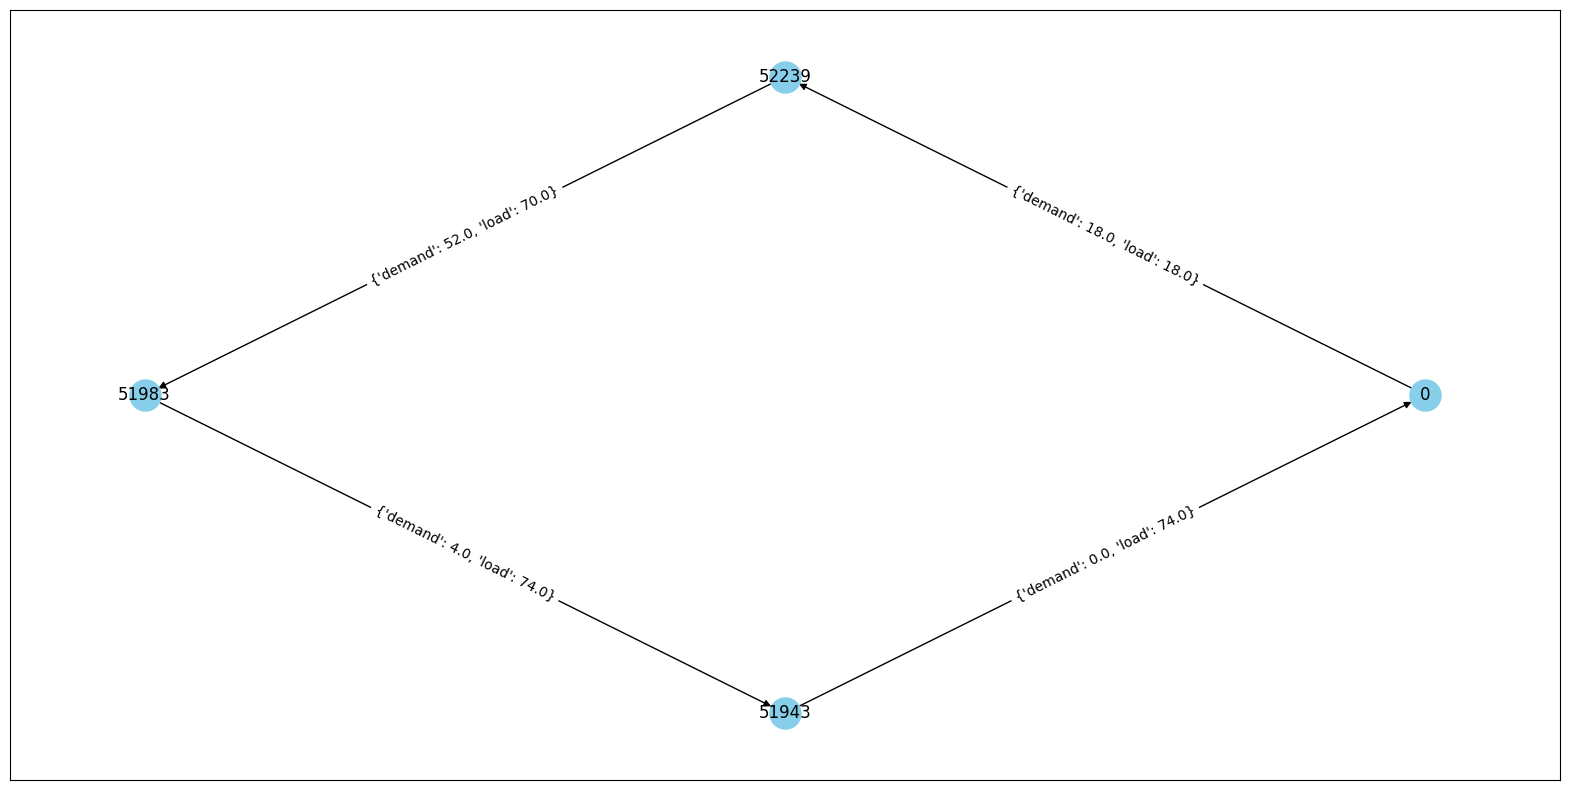



Bus 13:


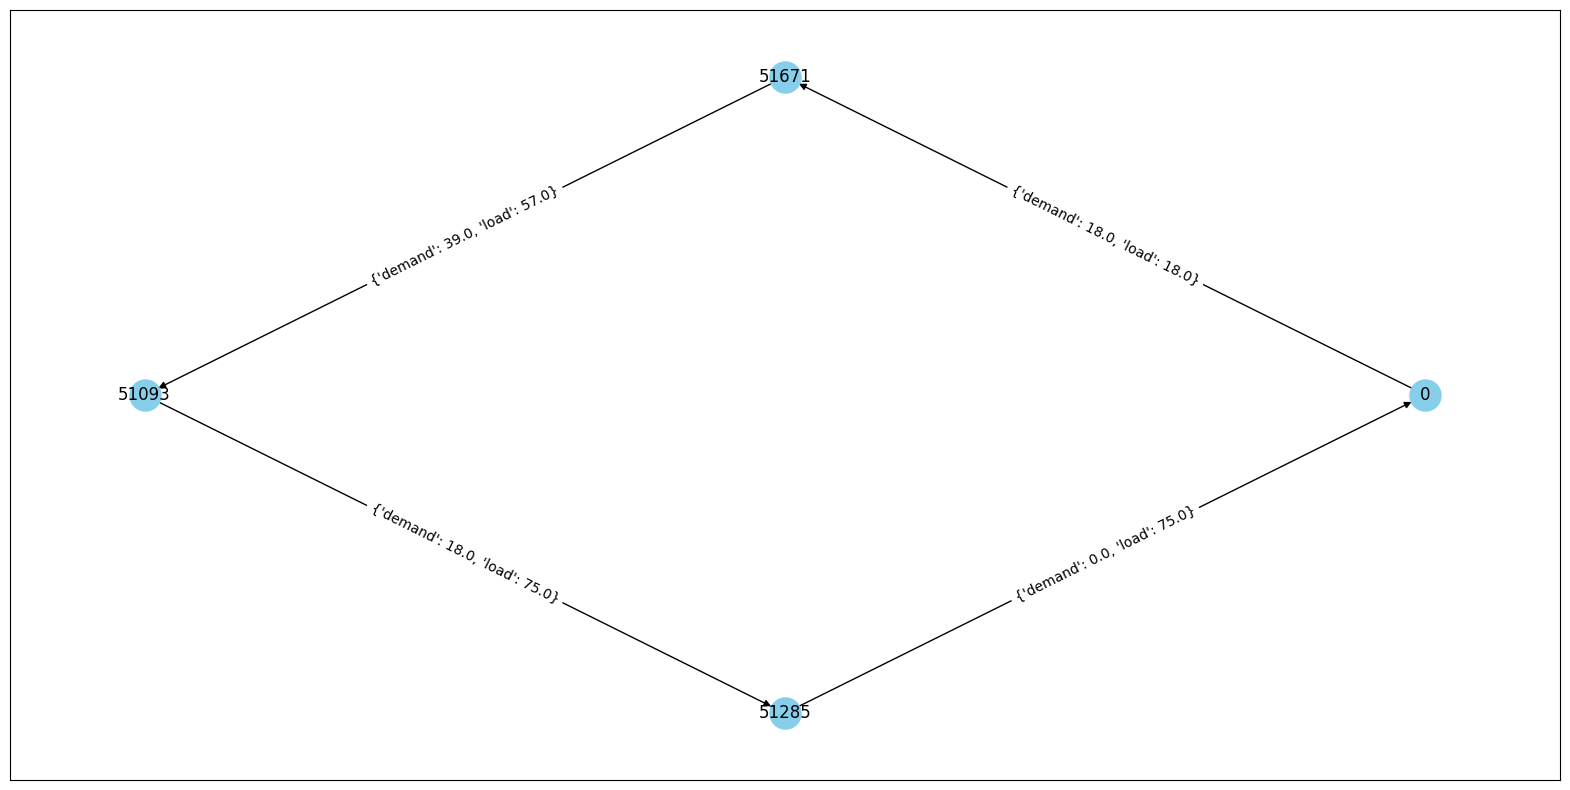



Bus 14:


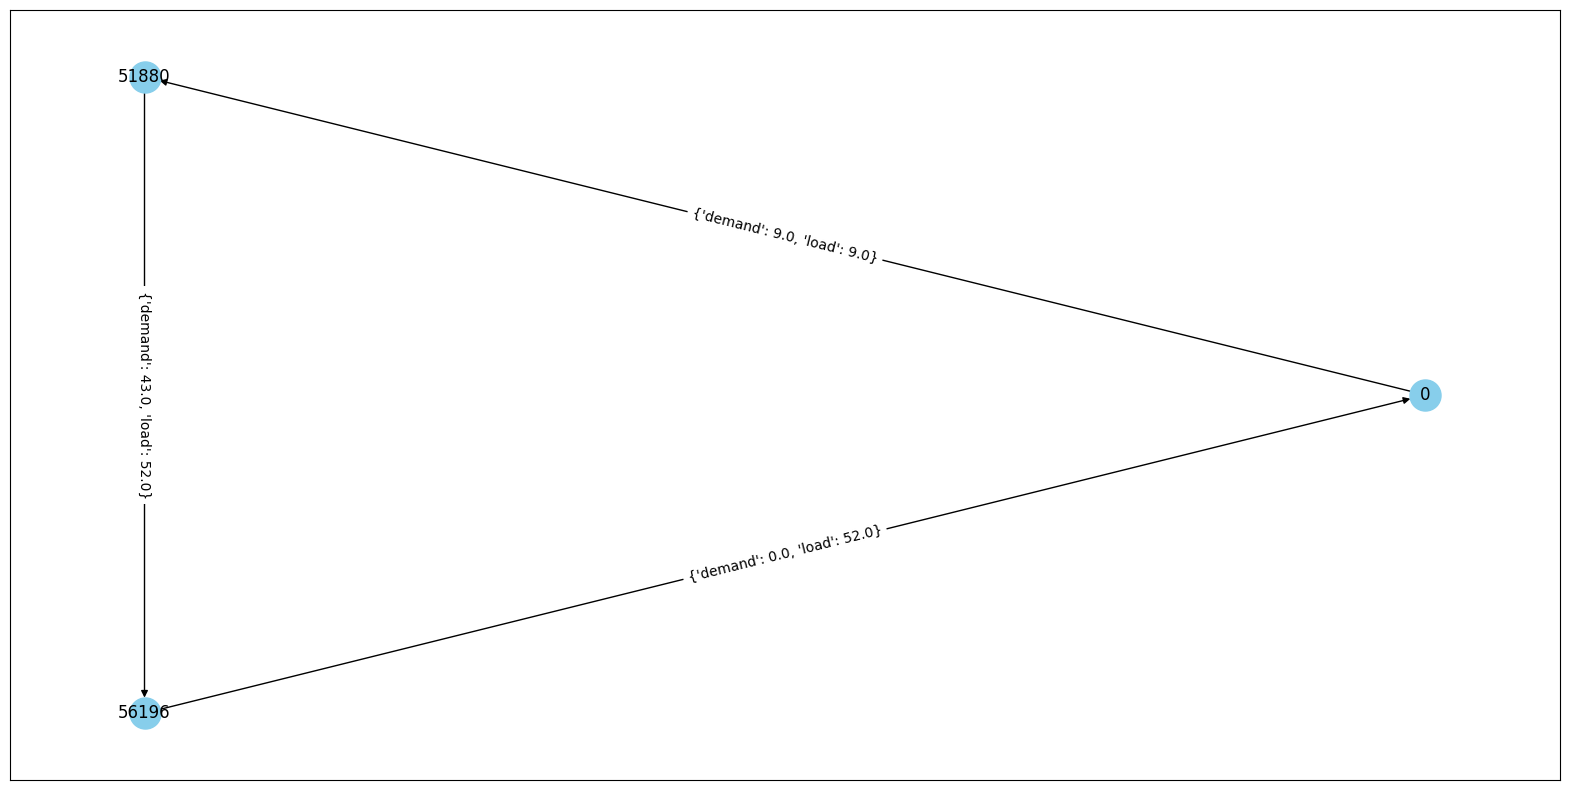



Bus 16:


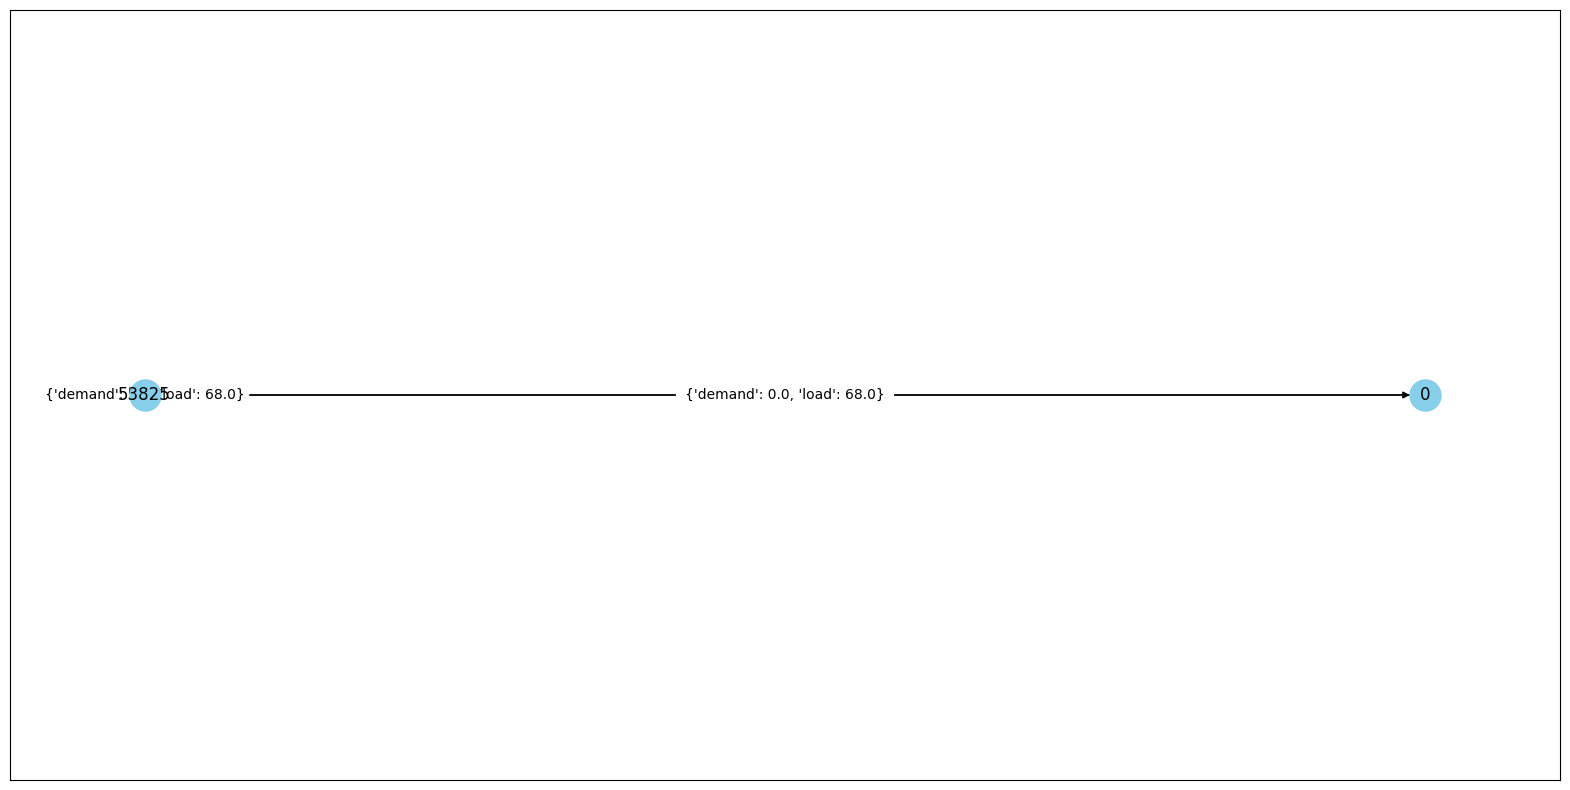



Bus 17:


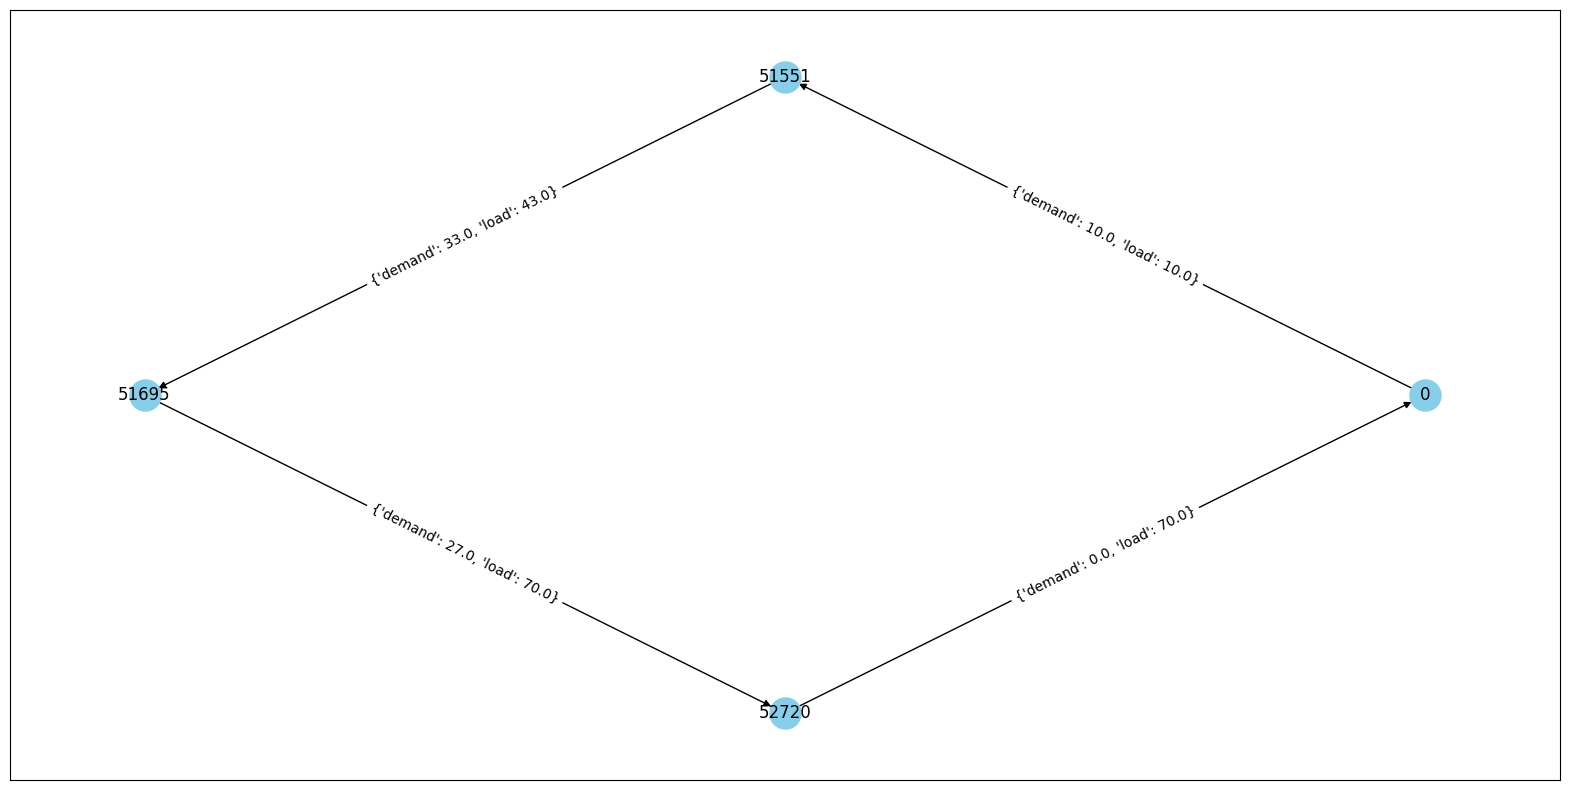



Bus 18:


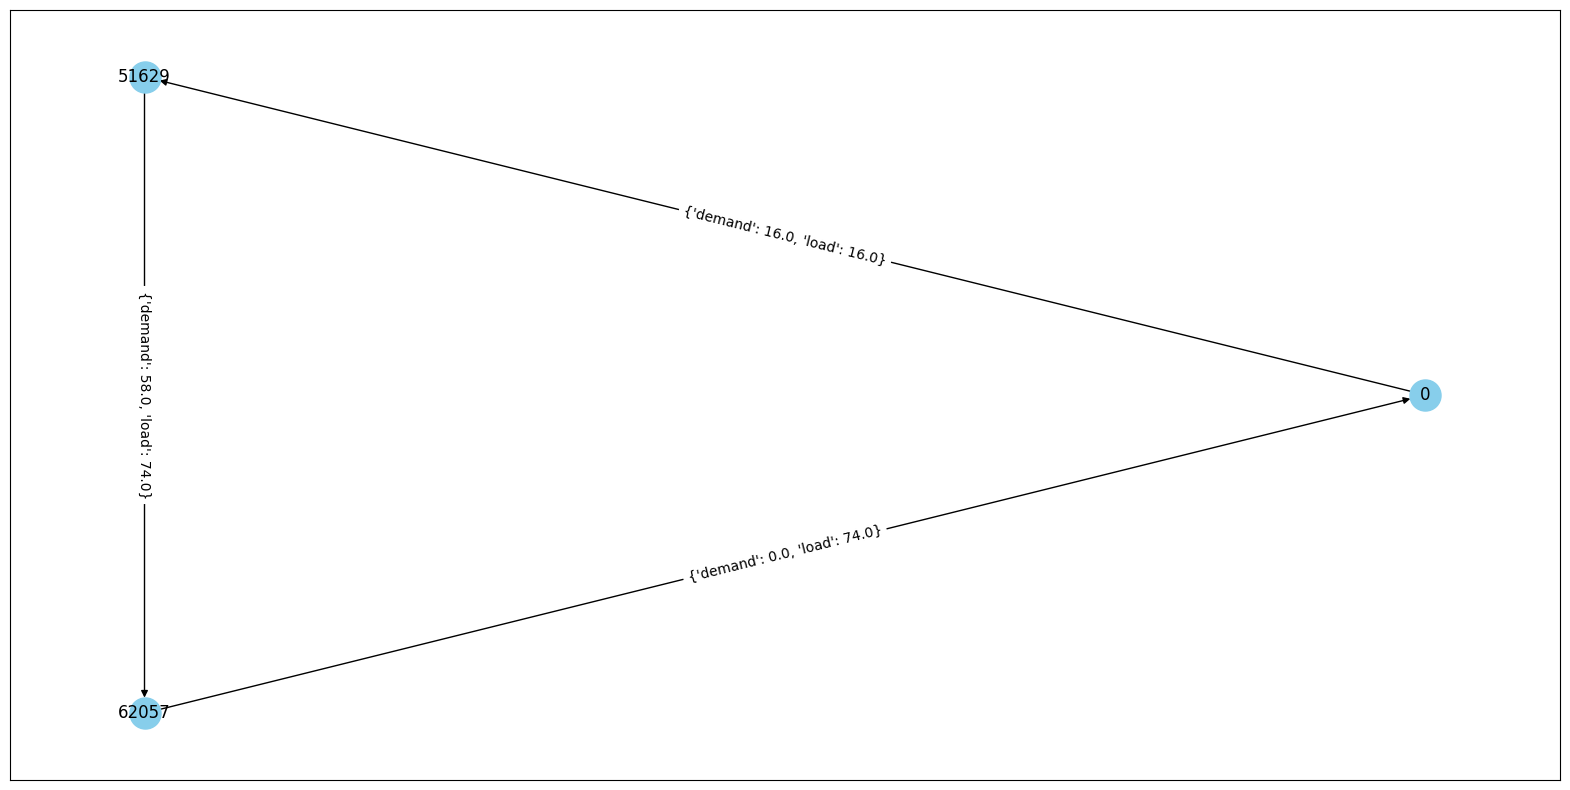



Bus 19:


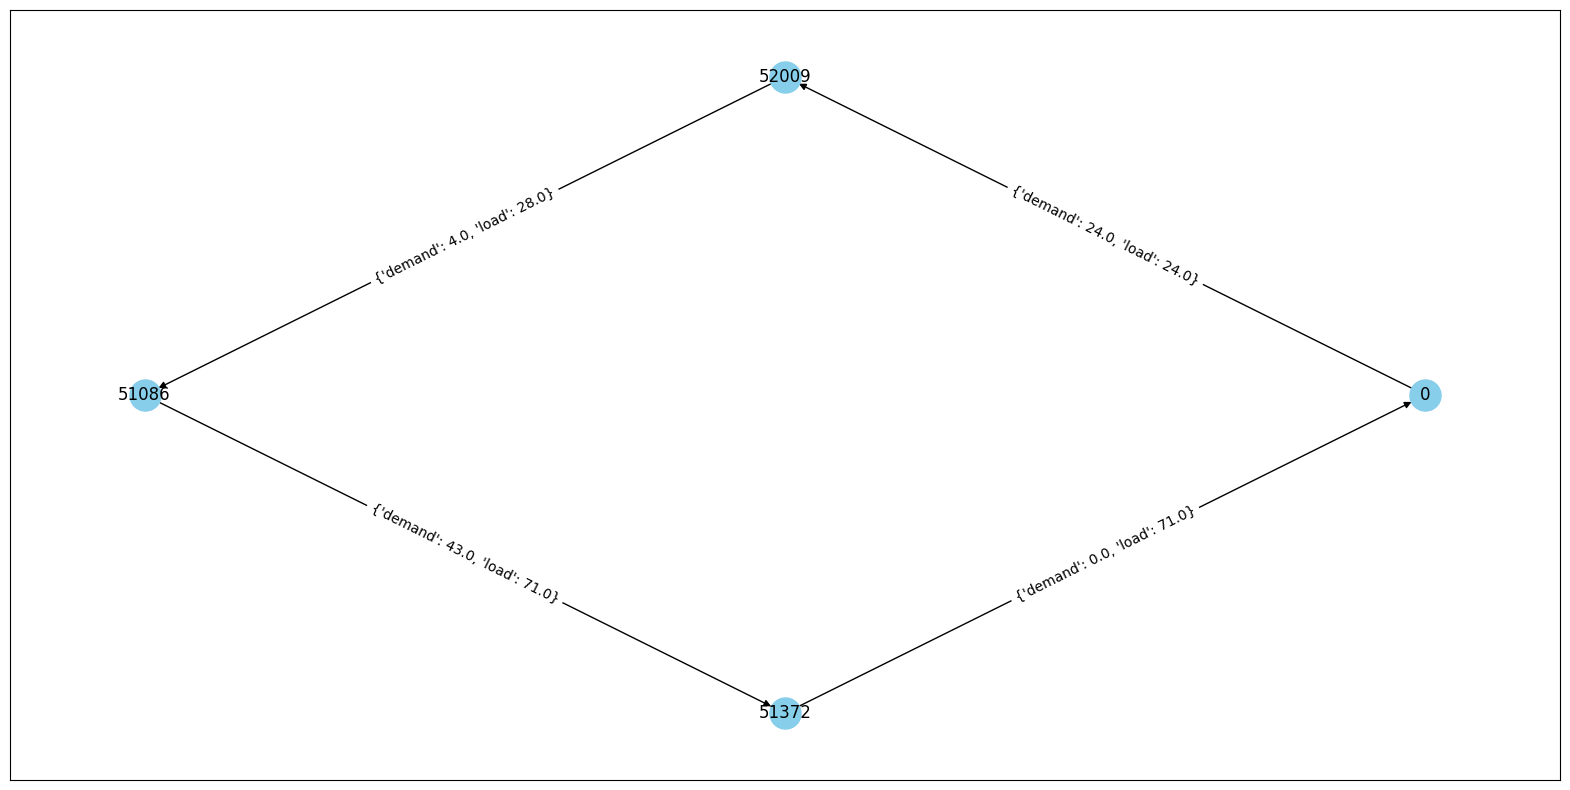



Bus 20:


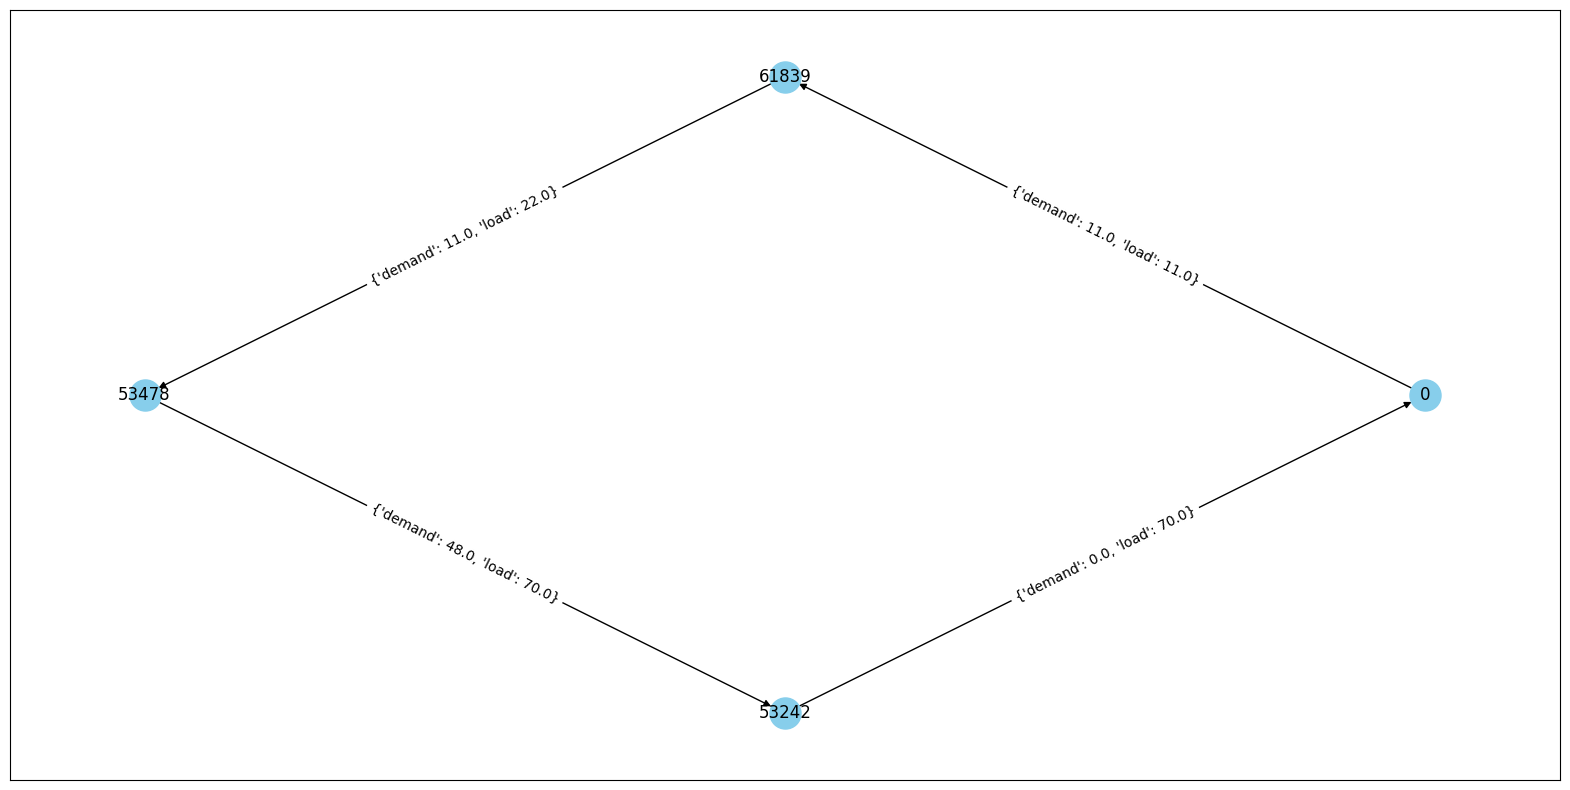

In [69]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [70]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

routes_gdf

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.60653 45.5...",73.0
1,1,"LINESTRING (-73.56912 45.50485, -73.64608 45.5...",42.0
2,2,"LINESTRING (-73.56912 45.50485, -73.62370 45.4...",75.0
3,3,"LINESTRING (-73.56912 45.50485, -73.62600 45.5...",66.0
4,4,"LINESTRING (-73.56912 45.50485, -73.59584 45.5...",74.0
5,5,"LINESTRING (-73.56912 45.50485, -73.62216 45.4...",69.0
6,6,"LINESTRING (-73.56912 45.50485, -73.53015 45.5...",75.0
7,7,"LINESTRING (-73.56912 45.50485, -73.51077 45.5...",69.0
8,8,"LINESTRING (-73.56912 45.50485, -73.61290 45.6...",57.0
9,9,"LINESTRING (-73.56912 45.50485, -73.51077 45.5...",66.0


### Map the routes

In [71]:
colormap = cm.get_cmap("tab20")

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(name=f"Route {route.bus + 1}")

    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=mcolors.rgb2hex(colormap.colors[route.Index]),
        weight=3,
        opacity=0.8,
        tooltip=f"Route {route.bus + 1}",
        popup=f"""
        <div>
            <h5>Route {route.bus + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map

In [72]:
route_map.save("route_map_3.html")